# 05_WindForcing

Relation to large-scale patterns of atm. forcing

In [1]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_NSIDC.icedrift as icedrift

In [2]:
def grab_atm(time_range, lat = 70.5 , lon = -140, dt = 'hourly'):

    def file_name(year, dt):
        if str(dt) == 'hourly':
            return f'/Volumes/Jewell_EasyStore/ECMWF/annual/hourly/ERA5_{year}.nc'
        else:
            return f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc'
            
    if time_range.stop.year != time_range.start.year:
        
        # year1
        DS1 = xr.open_dataset(file_name(time_range.start.year, dt))
        DS1.close()
        time_slice = slice(time_range.start, datetime(time_range.start.year, 12, 31, 23))
        DS1 = DS1.sel(latitude = lat, longitude = lon, time=time_slice)
        
        # year2
        DS2 = xr.open_dataset(file_name(time_range.stop.year, dt))
        DS2.close()
        time_slice = slice(datetime(time_range.stop.year, 1, 1, 0), time_range.stop)
        DS2 = DS2.sel(latitude = lat, longitude = lon, time=time_slice)

        # combine
        dsm = xr.concat([DS1, DS2], dim="time")
    
    else:
        
        # year1
        dsm = xr.open_dataset(file_name(time_range.start.year, dt))
        dsm.close()
        time_slice = time_range
        dsm = dsm.sel(latitude = lat, longitude = lon, time=time_slice)
        
    return dsm
    

In [3]:
def open_daily_winds(year, lat_range, lon_range, time_range = None):
    
    ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
    ds.close()
    if time_range == None:
        ds = ds.sel(latitude = lat_range, longitude = lon_range)
    else:
        ds = ds.sel(time = time_range, latitude = lat_range, longitude = lon_range)
        
    return ds

def open_daily_t2m(year, lat_range, lon_range, time_range = None):
    
    ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_{year}.nc')
    ds.close()
    
    if time_range == None:
        ds = ds.sel(latitude = lat_range, longitude = lon_range)
    else:
        ds = ds.sel(valid_time = time_range, latitude = lat_range, longitude = lon_range)
    
    return ds


def open_daily_drift(year, lat_range, lon_range, time_range = None):
    
    if time_range == None:
        dates = pd.to_datetime(pd.date_range(datetime(year,1,1),datetime(year,12,31), freq='1D'))
    else:
        dates = pd.to_datetime(pd.date_range(time_range.start, time_range.stop, freq='1D'))
        
    drift = icedrift.open_local_file(dates, crop = [200,300,110,200],include_units = False)
    
    
    drift2 = {}
    drift2['u'] = drift['u']
    drift2['v'] = drift['v']
    drift2['e'] = drift['e']
    drift2['n'] = drift['n']
    
    drift2['s'] = np.sqrt(drift['e']**2+drift['n']**2)

    return drift2



In [4]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

## Reference grids

In [503]:
grids = {}

# ERA5
#-----
era_lat_range = slice(74,68)
era_lon_range = slice(-165,-125)
ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_2024_daily.nc')
ds.close()
ds = ds.sel(latitude = era_lat_range, longitude = era_lon_range)
longrid, latgrid = np.meshgrid(ds.longitude, ds.latitude)

grids['era'] = {}
grids['era']['lat'] = latgrid
grids['era']['lon'] = longrid


# PPD drift
#----------
drift = icedrift.open_local_file(datetime(2023,1,1), crop = [200,300,110,200],include_units = False)
drift['lon'][drift['lon']>180]-=360
grids['ppd'] = {}
grids['ppd']['lat'] = drift['lat']
grids['ppd']['lon'] = drift['lon']
grids['ppd']['xx'] = drift['xx']
grids['ppd']['yy'] = drift['yy']


# open regional bounding coordinates
df = pd.read_csv('../data/local_coastal_region_bounds_v5.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))


from shapely.geometry import Point

for key in grids.keys():
    print(key)
    
    grids[key]['region'] = np.full(grids[key]['lon'].shape, False)

    for ii in range(np.shape(grids[key]['region'])[0]):
        for jj in range(np.shape(grids[key]['region'])[1]):

            lon, lat = grids[key]['lon'][ii,jj], grids[key]['lat'][ii,jj]
            if lon > 180:
                lon-=360

            if reg_poly.contains(Point(lon, lat)):
                
                if lon > -150:
                    grids[key]['region'][ii,jj] = True
                

era
ppd


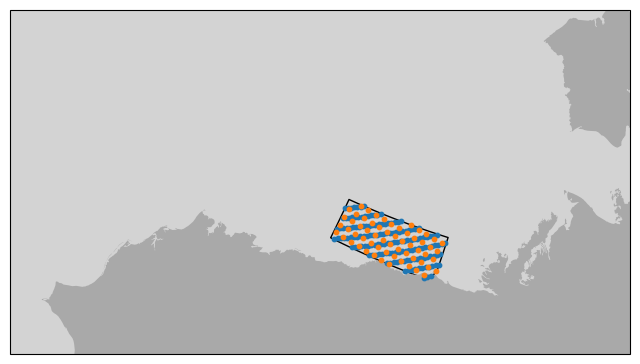

In [504]:

# initialize map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))
ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-800000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None', crs=ccrs.PlateCarree())


for key in ['era', 'ppd']:
    ax.scatter(grids[key]['lon'][grids[key]['region']], grids[key]['lat'][grids[key]['region']], zorder=100, s = 10, transform=ccrs.PlateCarree())


In [7]:

key = 'era'
mainpath = '../data/forcing/'
filename = f"dailymaps_{key}_v0.nc"
ds = xr.open_dataset(mainpath+filename)

In [502]:
import pyproj

# Define the bearing (in degrees) and the distance to travel (in meters)
#==================
bearing1 = 30
#==================
bearing2 = bearing1-90
bearing3 = bearing2-90
bearing4 = bearing3-90
# distance = 15000 # m
distance = 20000 # m

geod = pyproj.Geod(ellps='WGS84') # Create a Geod object

reg_lons = np.array([-139])
reg_lats = np.array([69.6])

reg_lonsp = np.copy(reg_lons)
reg_latsp = np.copy(reg_lats)

for ss in range(5):
    lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing1, distance)
    reg_lons = np.append(reg_lons, lon2)
    reg_lats = np.append(reg_lats, lat2)
    
for ss in range(15):
    lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing2, distance)
    reg_lons = np.append(reg_lons, lon2)
    reg_lats = np.append(reg_lats, lat2)
   
for ss in range(6):
    lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing3, distance)
    reg_lons = np.append(reg_lons, lon2)
    reg_lats = np.append(reg_lats, lat2)
    
for ss in range(15):
    lon2, lat2, _ = geod.fwd(reg_lons[-1], reg_lats[-1], bearing4, distance)
    reg_lons = np.append(reg_lons, lon2)
    reg_lats = np.append(reg_lats, lat2)
    
    
# reg_lons = np.append(reg_lons, np.array([-153, -145, -139.5]))
# reg_lats = np.append(reg_lats, np.array([70.1, 69.8, 69.3]))

region_lons = reg_lons
region_lats = reg_lats

reg_poly2 = geoshape.make_polygon(np.stack((region_lons, region_lats), axis=1))

# save coordinates to file
df = pd.DataFrame({'lons': region_lons,
                   'lats': region_lats})
df.to_csv('../data/local_coastal_region_bounds_v5.csv', index=False)  

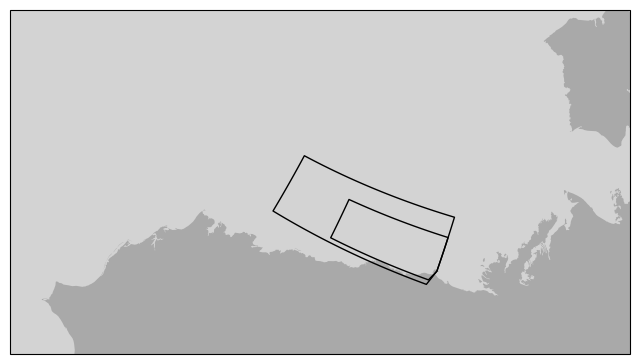

In [500]:

# initialize map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))
ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-800000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None', crs=ccrs.PlateCarree(), zorder=100)
ax.add_geometries([reg_poly2], edgecolor='k', facecolor='None', crs=ccrs.PlateCarree(), zorder=100)

# key = 'era'
# ax.pcolormesh(grids[key]['lon'], 
#               grids[key]['lat'], 
#               fieldmonth[key]['s10'][1]['mean'] - field[key]['s10']['mean'], vmin=-5, vmax=5, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


## Identify continuous polynya sequences

In [1395]:

all_seqs = {}
all_sizes = {}

#===============================
years = np.append(np.arange(2003,2012), np.arange(2013,2026))
# years = np.arange(2003,2026)

size_thresh = 50      # polynya must reach this size at some point to be counted as event (km2)
start_size_thresh = 50  # size of openings to include as full window of event (km2)
#===============================

days_per_year = []
events_per_year = []

for year in years:
    
    print(year)
    
    # open data and crop to time range
    DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic15_v5.nc')
    DS['length'] = DS.l_per95 - DS.l_per5
    DS['width'] = DS.w_per95 - DS.w_per5
    time_range = slice(datetime(year-1,12,1), datetime(year,3,31))
    DS = DS.sel(time = time_range)
    
    # identify open periods
    
    open_cond = (DS.extent > start_size_thresh) & (DS.ocean_extent == 0)
    open_dates = pd.to_datetime(DS.time[open_cond].values)
    days_per_year.append(len(open_dates))
    
    open_seqs = tseries.dates_to_sequences(open_dates, dt_max = 1 * units('day'))
    events_per_year.append(len(open_seqs))
    
    large_seqs = {}
    
    cc = 0
    for jj in range(len(open_seqs)):
        # if polynya reach size threshold during event, add to algre sequences
        if np.sum(DS.sel(time = open_seqs[jj]).extent.values > size_thresh) > 0:
            large_seqs[cc] = open_seqs[jj]
            cc+=1
        
    
    # add to master list
    ii = len(all_seqs)
    
    CC = 0
    for cc in range(len(large_seqs)):
        if len(large_seqs[cc]) > 1:
            all_seqs[ii+CC] = large_seqs[cc]
            all_sizes[ii+CC] = DS.extent.sel(time = large_seqs[cc]).values
            CC+=1
            
        
        

2003
2004
2005
2006
2007
2008
2009
2010
2011
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025


2003
2004
2005
2006
2007
2008
2009
2010
2011
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025


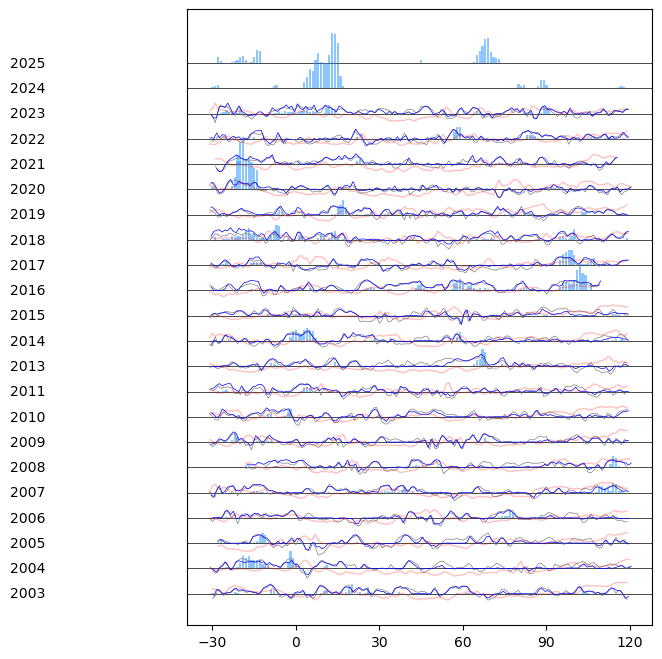

In [1400]:

    
fig, ax = plt.subplots(figsize=(6,8))


ax.set_xticks([-60,-30,0,30,60,90,120, 150])
ax.set_yticks([])

ax.set_ylim(-10, 185)

daily_counts = {}
long_wind_counts = {}
wind_counts = {}
polynya_counts = {}
months = [12, 1, 2, 3, 4]
for month in months:
    long_wind_counts[month] = {}
    wind_counts[month] = {}
    polynya_counts[month] = {}
    daily_counts[month] = {}
    for year in years:
        long_wind_counts[month][year] = 0
        wind_counts[month][year] = 0
        polynya_counts[month][year] = 0
        daily_counts[month][year] = 0
    
wind_durations = np.array([])    
    
compare = {}
compare['event'] = {}
compare['other'] = {}

groups = ['u10', 'v10', 'e', 'n']

for cat in compare.keys():
    compare[cat] = {}
    for group in groups:
        compare[cat][group] = np.array([])
        
        
        
annual_data = {}
annual_data['cum_polynya_extent'] = np.array([])
        
    
daily_data = {}
daily_data['ppd'] = {}
daily_data['era'] = {}
daily_data['pol'] = {}


daily_data['ppd']['ese'] = np.array([])
daily_data['ppd']['s'] = np.array([])
daily_data['ppd']['time'] = np.array([], dtype=np.datetime64)

daily_data['era']['ese'] = np.array([])
daily_data['era']['s'] = np.array([])
daily_data['era']['t2m'] = np.array([])
daily_data['era']['time'] = np.array([], dtype=np.datetime64)

daily_data['pol']['extent'] = np.array([])
daily_data['pol']['time'] = np.array([], dtype=np.datetime64)



for yy, year in enumerate(years):
    
    YY = yy * 8
    ax.axhline(YY, c='k', lw=0.5, zorder=-1)
    ax.text(-90, YY, year, va='center', ha='right', clip_on=False)
    print(year)
    
    # open polynya data and crop to time range
    #-----------------------------------------
    DSo = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic15_v5.nc')
    time_range = slice(datetime(year-1,12,1), datetime(year,4,30, 23))
    DSo = DSo.sel(time = time_range)
    
    # find first and last closure dates
    dt_og = (pd.to_datetime(DSo.time.values) - datetime(year,1,1)).days
    
    ice_area = (DSo.ice_extent.values)
    water_area = (DSo.polynya_extent + DSo.other_polynya_extent)
    total_area = (ice_area + water_area)
    
    first_closure_ind = np.where(ice_area/total_area > 0.99)[0][0]
    first_closure_date = dt_og[first_closure_ind]
    final_closure_ind = np.where(ice_area/total_area > 0.99)[0][-1]
    final_closure_date = dt_og[final_closure_ind]
    
    # crop data between first, last closure dates
    DS = DSo.sel(time = slice(DSo.time[first_closure_ind],DSo.time[final_closure_ind]))
    
    # re-define dt
    dt = (pd.to_datetime(DS.time.values) - datetime(year,1,1)).days
    
    # save annual cumulative polynya area (over compact period)
    annual_data['cum_polynya_extent'] = np.append(annual_data['cum_polynya_extent'], np.nansum(DS.polynya_extent) )
    
    daily_data['pol']['extent'] = np.append(daily_data['pol']['extent'], DS.polynya_extent)
    daily_data['pol']['time'] = np.append(daily_data['pol']['time'], DS.time)
    
    # plot polynya data
    ax.bar(dt, DS.polynya_extent/1000, bottom=YY, color='dodgerblue', alpha=0.5)
    
    
    
    # open daily wind data and crop to time range
    #----------------------------------------------
    if year < 2024:
        ds = xr.open_dataset(f'../data/forcing/regional_daily_era_{year}_v0.nc')
        crop_ds = ds.sel(time=slice(pd.to_datetime(DS.time.values[0]), pd.to_datetime(DS.time.values[-1])))
        dt2 = (pd.to_datetime(crop_ds.time.values) - datetime(year,1,1)).total_seconds()/(60*60*24)
        ESE = vectors.comp_along_theta(crop_ds.u10.values, crop_ds.v10.values, (-177.5)*units('degree'))
        
        daily_data['era']['t2m'] = np.append(daily_data['era']['t2m'], crop_ds.t2m)
        daily_data['era']['s'] = np.append(daily_data['era']['s'], crop_ds.s10)
        daily_data['era']['ese'] = np.append(daily_data['era']['ese'], ESE)
        daily_data['era']['time'] = np.append(daily_data['era']['time'], crop_ds.time)

        
        ax.plot(dt2, YY + 0.2*ESE, c='gray', lw=0.5)
        ax.plot(dt2, YY + 0.2*(crop_ds.t2m+20), c='r', lw=1, alpha=0.25)
    
    
    # open daily ice drift data and crop to time range
    #----------------------------------------------
    if year < 2024:
        dsp = xr.open_dataset(f'../data/forcing/regional_daily_ppd_{year}_v0.nc')
        dsp = dsp.sel(time = slice(DS.time[0], DS.time[-1]))
        dt = (pd.to_datetime(dsp.time.values) - datetime(year,1,1)).days
        ese = vectors.comp_along_theta(dsp.e.values, dsp.n.values, (162.5)*units('degree'))

        
        daily_data['ppd']['ese'] = np.append(daily_data['ppd']['ese'], ese)
        daily_data['ppd']['s'] = np.append(daily_data['ppd']['s'], dsp.s)
        daily_data['ppd']['time'] = np.append(daily_data['ppd']['time'], dsp.time)
        
        ax.plot(dt+0.5, YY+ 0.1*ese, c='b', lw=0.5)
        
    
    
    
# #    
    
    
# #     plt.plot(DS.ice_extent.values)
# #     ax.plot(dt, YY + water_area/1000, c='dodgerblue')
# #     ax.plot(dt, YY + DS.polynya_extent/1000, c='dodgerblue')
#     ax.bar(dt, DS.polynya_extent/1000, bottom=YY, color='dodgerblue', alpha=0.5)
# #     ax.plot(dt[1:], YY + np.diff(DS.polynya_extent.values)/1000, c='b', lw=0.5)
    
#     ax.scatter(first_closure_date, YY + water_area[first_closure_ind]/1000, marker='*', c='b', zorder=100)
#     ax.scatter(final_closure_date, YY + water_area[final_closure_ind]/1000, marker='*', c='b', zorder=100)
    
#     ax.scatter(dt[DS.polynya_extent>size_thresh], np.zeros(np.sum(DS.polynya_extent.values>size_thresh)) + YY, 
#                 c='r', s=5)
    
    
    
#     ds = xr.open_dataset(f'../data/forcing/regional_hourly_era_{year}_v0.nc')

#     crop_ds = ds.sel(time=slice(pd.to_datetime(DS.time.values[0]), pd.to_datetime(DS.time.values[-1])))
#     dt2 = (pd.to_datetime(crop_ds.time.values) - datetime(year,1,1)).total_seconds()/(60*60*24)
#     round_dt2 = np.array([math.floor(DT2) for DT2 in np.array(dt2)])
    
#     run_mean_u = tseries.running_mean(crop_ds.u10.values, length=1*24, center=False, address_nans=False)
#     run_mean_v = tseries.running_mean(crop_ds.v10.values, length=1*24, center=False, address_nans=False)

    
    
    
#     for t in dt[DS.polynya_extent > size_thresh]:
#         cat = 'event'
#         compare[cat]['u10'] = np.append(compare[cat]['u10'], run_mean_u[np.where(round_dt2 == t)])
#         compare[cat]['v10'] = np.append(compare[cat]['v10'], run_mean_v[np.where(round_dt2 == t)])
#     for t in dt[DS.polynya_extent <=size_thresh]:
#         cat = 'other'
#         compare[cat]['u10'] = np.append(compare[cat]['u10'], run_mean_u[np.where(round_dt2 == t)])
#         compare[cat]['v10'] = np.append(compare[cat]['v10'], run_mean_v[np.where(round_dt2 == t)])
    
    
# #     run_mean_u = crop_ds.u10.values
# #     run_mean_v = crop_ds.v10.values

    
#     ESE_mean = vectors.comp_along_theta(run_mean_u, run_mean_v, (150+25)*units('degree'))
#     ESE = vectors.comp_along_theta(crop_ds.u10.values, crop_ds.v10.values, (150+25)*units('degree'))
    
#     speeds = np.sqrt(run_mean_u**2+run_mean_v**2)
#     angles = vectors.vector_angle(run_mean_u, run_mean_v).magnitude
# #     force_dir = (angles > 145) + (angles < -170)
# #     force_dir = (angles > (170-22.5)) + (angles < -180 + (22.5-10))
#     force_dir = (angles > (137.5)) + (angles < -152.5)
    
#     open_cond = force_dir & (speeds > 5)
#     event_times = pd.to_datetime(crop_ds.time.values)
#     consecutive_open = tseries.dates_to_sequences(event_times[open_cond], dt_max = 1 * units('hour'))

#     for ss in consecutive_open.keys():
#         wind_durations = np.append(wind_durations, len(consecutive_open[ss]))
        
#         if len(consecutive_open[ss]) > 48: 
#             for date in consecutive_open[ss]:
#                 long_wind_counts[date.month][year] += 1
        
        
#     # save counts of polynya events and wind events
#     for date in event_times[open_cond]:
#         wind_counts[date.month][year]+=1
#     for date in pd.to_datetime(DS.time[DS.polynya_extent > size_thresh]):
#         polynya_counts[date.month][year]+=1
#     for date in pd.to_datetime(DS.time):
#         daily_counts[date.month][year]+=1
    
#     cum_open = np.zeros(len(ESE))
#     for cc in consecutive_open:
#         start = np.where(event_times == consecutive_open[cc][0])[0][0]
#         final = np.where(event_times == consecutive_open[cc][-1])[0][0]
# #         cum_open[start:final+1] = np.cumsum(0.03*ESE[start:final+1])
#         cum_open[start:final] = (ESE_mean[start:final])

    
    
    
#     copy_ESE = np.copy(ESE_mean)
#     copy_ESE[open_cond == False] = np.nan
#     ax.plot(dt2, YY + 0.4*ESE_mean, c='darkgray', lw=0.5)
#     ax.plot(dt2, YY + 0.4*copy_ESE, c='k', lw=0.5)
    
    
    
    
    
# #     ax.plot(dt2, YY + 0.5*cum_open, c='r', lw=0.5)
    
    
#     daily_ESE = np.array([])
#     daily_cum_open = np.array([])
#     for DT in dt:
#         daily_ESE = np.append(daily_ESE, np.nanmean(ESE[np.where(round_dt2 == DT)[0]]))
#         daily_cum_open = np.append(daily_cum_open, np.nanmean(cum_open[np.where(round_dt2 == DT)[0]]))
    

#     # plot t2m
# #     ds2 = xr.open_dataset(f'../data/forcing/regional_daily_era_{year}_v0.nc')
# #     crop_ds2 = ds2.sel(time=slice(pd.to_datetime(DS.time.values[0]), pd.to_datetime(DS.time.values[-1])))
# #     dt2 = (pd.to_datetime(crop_ds2.time.values) - datetime(year,1,1)).total_seconds()/(60*60*24)
# #     ax.plot(dt2, YY + 0.2*(crop_ds2.t2m+20), c='r', lw=1, alpha=0.5)
    

        
#         for t in dt[DS.polynya_extent > size_thresh]:
#             cat = 'event'
#             compare[cat]['e'] = np.append(compare[cat]['e'], dsp.e.values[np.where(dt == t)])
#             compare[cat]['n'] = np.append(compare[cat]['n'], dsp.n.values[np.where(dt == t)])
#         for t in dt[DS.polynya_extent <=size_thresh]:
#             cat = 'other'
#             compare[cat]['e'] = np.append(compare[cat]['e'], dsp.e.values[np.where(dt == t)])
#             compare[cat]['n'] = np.append(compare[cat]['n'], dsp.n.values[np.where(dt == t)])
        

#     ax.plot()
fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=330, bbox_inches='tight')



for cat in ['event', 'other']:
    compare[cat]['angles'] = vectors.vector_angle(compare[cat]['u10'], compare[cat]['v10'])
    compare[cat]['speed'] = np.sqrt(compare[cat]['u10']**2 + compare[cat]['v10']**2)
    compare[cat]['angles_ppd'] = vectors.vector_angle(compare[cat]['e'], compare[cat]['n'])
    compare[cat]['speed_ppd'] = np.sqrt(compare[cat]['e']**2 + compare[cat]['n']**2)

In [1251]:
for key in daily_data.keys():
    daily_data[key]['time'] = pd.to_datetime(daily_data[key]['time']) 
    daily_data[key]['month'] = np.array([date.month for date in daily_data[key]['time']])
    daily_data[key]['year'] = np.array([date.year if date.month!=12 else date.year-1 for date in daily_data[key]['time']])

17.681818181818183
16.772727272727273
15.0
17.045454545454547
18.90909090909091


[Text(0, 0, '12'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4')]

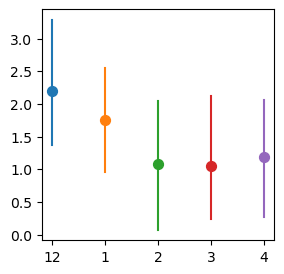

In [1312]:
fig, ax = plt.subplots(figsize=(3,3))

# ax.scatter(daily_data['era']['month'], daily_data['ppd']['ese'], s=1)

for mm, month in enumerate(months):
    
    mean_ppd_ese = np.nanmean(daily_data['ppd']['ese'][daily_data['ppd']['month']==month])
    mean_era_ese = np.nanmean(daily_data['era']['ese'][daily_data['era']['month']==month])
    
    
    cond = (daily_data['era']['ese'] > 0) & (daily_data['ppd']['month']==month)
    print(np.sum(cond)/len(years))
    monthly_wf = (daily_data['ppd']['ese']/daily_data['era']['ese'])[cond]
    
#     ax.scatter(mm, mean_ppd_ese/mean_era_ese, s=1)
    
    ax.scatter(mm, np.nanmedian(monthly_wf), s=50)
    
    ax.plot([mm,mm], [np.nanpercentile(monthly_wf, 25),
                      np.nanpercentile(monthly_wf, 75)], )

ax.set_xticks(range(len(months)))
ax.set_xticklabels(months)

# ax.scatter(daily_data['ppd']['ese'], daily_data['era']['t2m'], s=1)
# ax.scatter(daily_data['ppd']['ese'], daily_data['pol']['extent'], s=5)

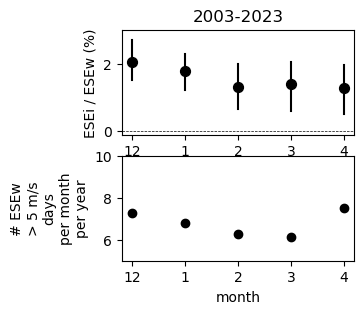

In [1394]:
fig, axs = plt.subplots(2,1,figsize=(3,3))

# ax.scatter(daily_data['era']['month'], daily_data['ppd']['ese'], s=1)

month_colors =['k', 'b', 'dodgerblue', 'lightcoral', 'r']

for mm, month in enumerate(months):

#         if month == 4:
    cond = (daily_data['ppd']['month']==month)# & (daily_data['ppd']['month']==month)
    cond = (cond) & (daily_data['era']['ese'] > 5)

    ax=axs[1]
    
    monthly_days_per_year = np.sum(daily_data['ppd']['month']==month) / len(years[:-2])
    ax.scatter(mm, np.sum(cond)/monthly_days_per_year, c='k')
#     ax.scatter(year, np.sum(cond)/len(cond))
#     mean_ppd_ese = np.nanmean(daily_data['ppd']['s'][cond])
#     mean_era_ese = np.nanmean(daily_data['era']['s'][cond])

    annual_wf = (daily_data['ppd']['ese']/daily_data['era']['s'])[cond]

#     ax.scatter(mm, mean_ppd_ese/mean_era_ese, s=1)

    ax=axs[0]
    dx = (mm - 2.5)/10
    ax.scatter(mm, np.nanmedian(annual_wf), s=50,  c='k')#c=month_colors[mm])

    ax.plot([mm, mm], [np.nanpercentile(annual_wf, 25),
                      np.nanpercentile(annual_wf, 75)],  c='k')#c=month_colors[mm])

            
ax.set_title('2003-2023')

ax = axs[0]
ax.set_ylim(-0.1,3)
ax.axhline(0,c='k', lw=0.5, ls='dashed')
ax.set_ylabel('ESEi / ESEw (%)')

ax.set_xticks(np.arange(len(months)))
ax.set_xticklabels(months)

ax = axs[1]
ax.set_ylim(5,10)
# ax.axhline(0,c='k', lw=0.5, ls='dashed')
# ax.set_yticks([0,30,60,90,120]);
ax.set_ylabel('# ESEw\n> 5 m/s\ndays\nper month\nper year')


ax.set_xticks(np.arange(len(months)))
ax.set_xticklabels(months)
ax.set_xlabel('month')
    
fig.savefig('/Users/mackenziejewell/Desktop/img.png', dpi=300, bbox_inches='tight')

# ax.set_xticks(range(len(months)))
# ax.set_xticklabels(months)

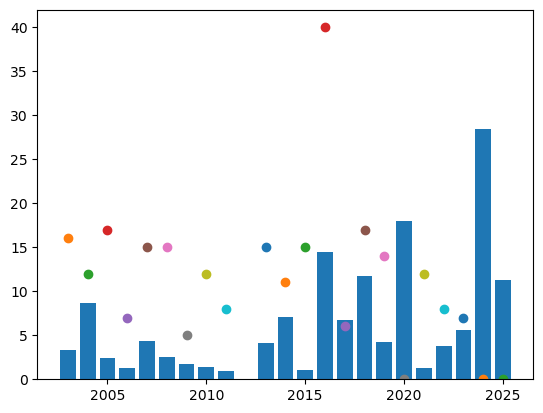

In [1291]:
fig, ax = plt.subplots()
ax.bar(years, annual_data['cum_polynya_extent']/5000, )

for year in years:
    
    cond = (daily_data['era']['year']==year) #& (daily_data['ppd']['month']==1)

    ax.scatter(year,np.nansum(daily_data['era']['ese'][cond] > 10))
    

In [1277]:
cond

array([False, False, False, ..., False, False, False])

In [1161]:
speed_thresh = (compare['event']['speed'] > 5) 
angle_thresh = (compare['event']['angles'].magnitude > 135) + (compare['event']['angles'].magnitude < -170)

np.nansum(speed_thresh&angle_thresh) / np.sum(np.isfinite(compare['event']['speed']))

0.7876395317179418

In [1162]:
speed_thresh = (compare['other']['speed'] > 5) 
angle_thresh = (compare['other']['angles'].magnitude > 135) + (compare['other']['angles'].magnitude < -170)

np.nansum(speed_thresh&angle_thresh) / np.sum(np.isfinite(compare['other']['speed']))

0.1495519457901903

In [1163]:
0.757725587144623/0.1426732797589151

5.310914478345239

[-177.5 -172.5 -167.5 -162.5  132.5  137.5  142.5  147.5  152.5  157.5
  162.5  167.5  172.5  177.5]
[-180 -175 -170 -165  130  135  140  145  150  155  160  165  170  175]


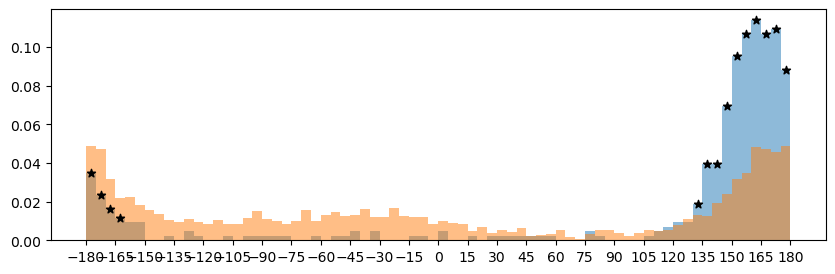

In [1173]:

fig, ax = plt.subplots(figsize=(10,3))
bin_edges = np.arange(-180, 181, 5)
db = np.diff(bin_edges)[0]
bin_centers = bin_edges[:-1] + db/2
event_vals, event_edges = np.histogram(compare['event']['angles_ppd'].magnitude, bins = bin_edges, density=False)
plt.bar(bin_centers, event_vals/len(compare['event']['angles_ppd']), width=db, align='center',alpha=0.5)

other_vals, other_edges = np.histogram(compare['other']['angles_ppd'].magnitude, bins = bin_edges, density=False)
plt.bar(bin_centers, other_vals/len(compare['other']['angles_ppd']), width=db, align='center',alpha=0.5)


thresh = (event_vals*db/len(compare['event']['angles_ppd'])) > 0.05
plt.scatter(bin_centers[thresh], (event_vals/len(compare['event']['angles_ppd']))[thresh], marker='*', c='k')
print(bin_centers[thresh])
print(bin_edges[:-1][thresh])

# plt.hist(compare['other']['angles'], bins=bins, alpha=0.5, density=True)
ax.set_xticks(bin_edges[::3]);

In [1175]:
bin_centers[np.argmax(event_vals)]

162.5

In [1111]:
np.sum((event_vals)[thresh])/len(compare['event']['angles_ppd'])

0.8876889848812095

[ 2.  4.  6.  8. 10. 12. 14. 16. 18. 20. 22. 24. 26. 28. 30. 32.]
[ 1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31]


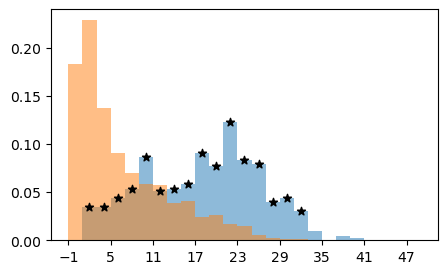

In [1165]:

fig, ax = plt.subplots(figsize=(5,3))
bin_edges = np.arange(-1, 50, 2)
db = np.diff(bin_edges)[0]
bin_centers = bin_edges[:-1] + db/2
event_vals, event_edges = np.histogram(compare['event']['speed_ppd'], bins = bin_edges, density=False)
plt.bar(bin_centers, event_vals/len(compare['event']['speed_ppd']), width=db, align='center',alpha=0.5)

other_vals, other_edges = np.histogram(compare['other']['speed_ppd'], bins = bin_edges, density=False)
plt.bar(bin_centers, other_vals/len(compare['other']['speed_ppd']), width=db, align='center',alpha=0.5)


thresh = (event_vals*db/len(compare['event']['speed_ppd'])) > 0.05
plt.scatter(bin_centers[thresh], (event_vals/len(compare['event']['speed_ppd']))[thresh], marker='*', c='k')
print(bin_centers[thresh])
print(bin_edges[:-1][thresh])

# plt.hist(compare['other']['angles'], bins=bins, alpha=0.5, density=True)
ax.set_xticks(bin_edges[::3]);

4.711433790735862
[ 5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5]
[ 5  6  7  8  9 10 11 12 13]


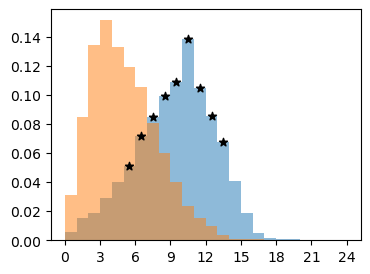

In [1166]:



fig, ax = plt.subplots(figsize=(4,3))
bin_edges = np.arange(0,25,1)
db = np.diff(bin_edges)[0]
bin_centers = bin_edges[:-1] + db/2
event_vals, event_edges = np.histogram(compare['event']['speed'], bins = bin_edges, density=False)
plt.bar(bin_centers, event_vals/len(compare['event']['speed']), width=db, align='center',alpha=0.5)

other_vals, other_edges = np.histogram(compare['other']['speed'], bins = bin_edges, density=False)
plt.bar(bin_centers, other_vals/len(compare['other']['speed']), width=db, align='center',alpha=0.5)
print(np.nanmedian(compare['other']['speed']))
# plt.bar(bin_centers, event_vals/other_vals, width=db, align='center',alpha=0.5)


# thresh = (event_vals/other_vals) > 1.
# plt.scatter(bin_centers[thresh], (event_vals/other_vals)[thresh], marker='*', c='k')
# print(bin_centers[thresh])
# print(bin_edges[:-1][thresh])

thresh = (event_vals*db)/len(compare['event']['speed']) > 0.05
plt.scatter(bin_centers[thresh], (event_vals/len(compare['event']['speed']))[thresh], marker='*', c='k')
print(bin_centers[thresh])
print(bin_edges[:-1][thresh])

# plt.hist(compare['other']['angles'], bins=bins, alpha=0.5, density=True)
ax.set_xticks(bin_edges[::3]);

In [1046]:
np.sum(compare['event']['speed'] > 5) / len(compare['event']['speed'])

0.8832906119833387

In [1047]:
np.sum(compare['other']['speed'] > 5) / len(compare['other']['speed'])

0.4604254021498818

In [1048]:
np.nanpercentile(compare['other']['speed'], 90)

8.924008805412962

[-177.5 -172.5 -167.5 -162.5 -157.5 -152.5 -147.5  107.5  122.5  127.5
  132.5  137.5  142.5  147.5  152.5  157.5  162.5  167.5  172.5  177.5]
[-180 -175 -170 -165 -160 -155 -150  105  120  125  130  135  140  145
  150  155  160  165  170  175]


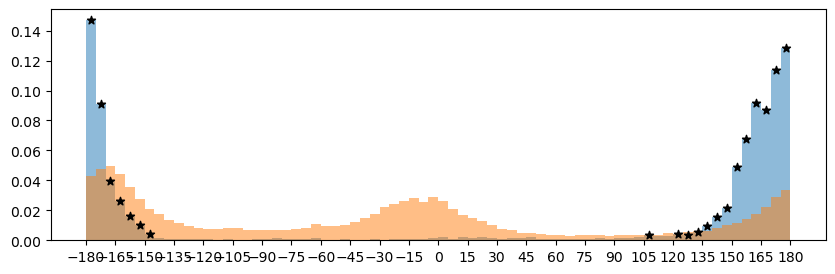

In [1176]:



fig, ax = plt.subplots(figsize=(10,3))
bin_edges = np.arange(-180, 181, 5)
db = np.diff(bin_edges)[0]
bin_centers = bin_edges[:-1] + db/2
event_vals, event_edges = np.histogram(compare['event']['angles'].magnitude, bins = bin_edges, density=False)
plt.bar(bin_centers, event_vals/len(compare['event']['angles']), width=db, align='center',alpha=0.5)

other_vals, other_edges = np.histogram(compare['other']['angles'].magnitude, bins = bin_edges, density=False)
plt.bar(bin_centers, other_vals/len(compare['other']['angles']), width=db, align='center',alpha=0.5)

# plt.bar(bin_centers, event_vals/other_vals, width=db, align='center',alpha=0.5)


# thresh = (event_vals/other_vals) > 1.
# plt.scatter(bin_centers[thresh], (event_vals/other_vals)[thresh], marker='*', c='k')
# print(bin_centers[thresh])
# print(bin_edges[:-1][thresh])

thresh = (event_vals/len(event_vals)) > 0.5
plt.scatter(bin_centers[thresh], (event_vals/len(compare['event']['angles']))[thresh], marker='*', c='k')
print(bin_centers[thresh])
print(bin_edges[:-1][thresh])

# plt.hist(compare['other']['angles'], bins=bins, alpha=0.5, density=True)
ax.set_xticks(bin_edges[::3]);

In [1177]:
bin_centers[np.argmax(event_vals)]

-177.5

In [1026]:
np.sum((event_vals/len(event_vals))[thresh])

85.98611111111111

In [1051]:
total_wind_hours = 0

for mm, month in enumerate(months):
    for year in years:
        total_wind_hours += wind_counts[month][year]
                                  

In [1052]:
total_wind_hours

26892

In [1053]:
bin_edges = np.arange(0.5,24*30,12)
db = np.diff(bin_edges)[0]
bin_centers = bin_edges[:-1] + db/2
bin_vals, xx = np.histogram(wind_durations, bins = bin_edges, density=False)

In [1054]:
np.sum((bin_vals * bin_centers) )/total_wind_hours

1.0031607913134017

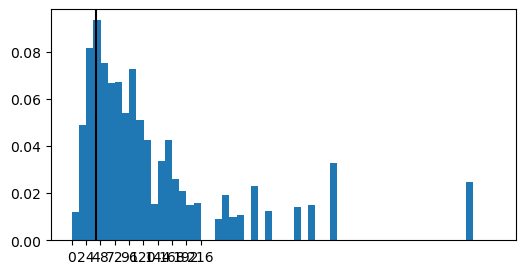

In [1055]:
fig, ax = plt.subplots(figsize=(6,3))

ax.set_xticks(np.arange(0,24*10,24))

ax.bar(bin_edges[:-1], (bin_vals * bin_centers) / total_wind_hours, width=db, align='edge')

# ax.bar(bin_edges[:-1], bin_vals, width=db, align='edge')

ax.axvline(np.nanpercentile(wind_durations,50), c='k')

In [706]:
len(bin_edges[:-1][thresh]) / len(bin_edges[:-1])

0.19444444444444445

In [621]:
anlgs < -170

array([-31, -31, -31, ..., 118, 118, 119])

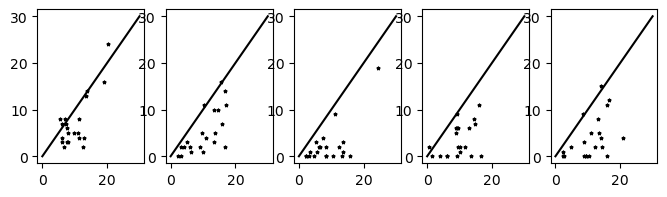

In [1167]:
fig, axs = plt.subplots(1, len(months), figsize=(8,2))

month_shapes = ['*', '*', 's', 'o', 'o']
month_colors = ['b', 'dodgerblue', 'gray', 'lightcoral', 'None']
edge_colors = ['None', 'None', 'k', 'None', 'k']



for mm, month in enumerate(months):
    
    ax = axs[mm]
    ax.plot([0,30], [0,30], c='k')
    
    for year in years:
        

        ax.scatter(wind_counts[month][year]/24, 
                   polynya_counts[month][year], 
                   s=5, c='k', marker='*')
#                    marker=month_shapes[mm], 
#                    facecolor=month_colors[mm],
#                   edgecolor=edge_colors[mm])

[Text(0, 0, '12'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4')]

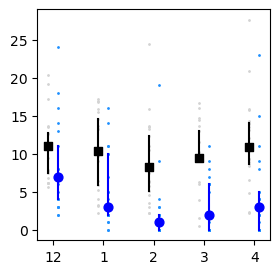

In [1114]:
fig, ax = plt.subplots(figsize=(3,3))

for mm, month in enumerate(months):
    
    monthly_winds = np.array([])
    for year in years:
        monthly_winds = np.append(monthly_winds, wind_counts[month][year]/24)
    
    monthly_polynyas = np.array([])
    for year in years:
        monthly_polynyas = np.append(monthly_polynyas, polynya_counts[month][year])
    
    dx = -0.1
    ax.scatter(np.full(len(years), mm+dx), monthly_winds, c='lightgray', s=1)
    color = 'k'
    ax.scatter(mm+dx, np.nanpercentile(monthly_winds, 50), c=color, marker='s', s=40)
    ax.plot([mm+dx,mm+dx], [np.nanpercentile(monthly_winds, 25),np.nanpercentile(monthly_winds, 75)], c=color)
    
    dx = 0.1
    color = 'blue'
    ax.scatter(np.full(len(years), mm+dx), monthly_polynyas, c='dodgerblue', s=1)
    ax.scatter(mm+dx, np.nanpercentile(monthly_polynyas, 50),  c=color, marker='o', s=40)
    ax.plot([mm+dx,mm+dx], [np.nanpercentile(monthly_polynyas, 25),np.nanpercentile(monthly_polynyas, 75)], c=color)
    

ax.set_xticks(range(len(months)))
ax.set_xticklabels(months)

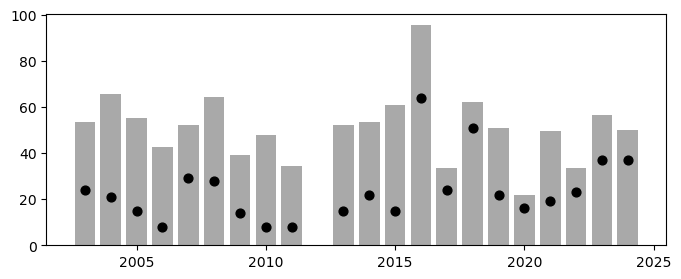

In [1115]:
fig, ax = plt.subplots(figsize=(8,3))

for yy, year in enumerate(years):
    
    annual_winds = np.array([])
    for month in months:
        annual_winds = np.append(annual_winds, wind_counts[month][year]/24)
    
    annual_polynyas = np.array([])
    for month in months:
        annual_polynyas = np.append(annual_polynyas, polynya_counts[month][year])
    
#     dx = -0.1
#     ax.scatter(np.full(len(months), year+dx), annual_winds, c='lightgray', s=1)
#     color = 'k'
#     ax.scatter(year+dx, np.nanpercentile(annual_winds, 50), c=color, marker='s', s=40)
#     ax.plot([year+dx,year+dx], [np.nanpercentile(annual_winds, 25),np.nanpercentile(annual_winds, 75)], c=color)
    
#     dx = 0.1
#     color = 'blue'
#     ax.scatter(np.full(len(months), year+dx), annual_polynyas, c='dodgerblue', s=1)
#     ax.scatter(year+dx, np.nanpercentile(annual_polynyas, 50),  c=color, marker='o', s=40)
#     ax.plot([year+dx,year+dx], [np.nanpercentile(annual_polynyas, 25),np.nanpercentile(annual_polynyas, 75)], c=color)
    

    dx = -0.1
    color='k'
    ax.bar(year, np.sum(annual_winds),   color='darkgray')

    dx = 0.1
    color = 'blue'
    ax.scatter(year, np.sum(annual_polynyas),   c='k', marker='o', s=40)

# ax.set_xticks(range(len(months)))
# ax.set_xticklabels(months)

In [948]:
from scipy import stats


2003
2004
2005
2006
2007
2008
2009
2010
2011
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
0.6461208371730984
0.41747213622926554


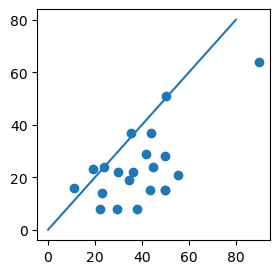

In [1117]:
fig, ax = plt.subplots(figsize=(3,3))

ax.plot([0,80], [0,80])

x = np.array([])
y = np.array([])
for yy, year in enumerate(years[:]):
    
    print(year)
    
    annual_winds = np.array([])
    for month in months:
        annual_winds = np.append(annual_winds, long_wind_counts[month][year]/24)
    
    annual_polynyas = np.array([])
    for month in months:
        annual_polynyas = np.append(annual_polynyas, polynya_counts[month][year])
    
    
    x = np.append(x, np.sum(annual_winds))
    y = np.append(y, np.sum(annual_polynyas))
    
ax.scatter(x,y)

res = stats.linregress(x, y)

print(res.rvalue)
print(res.rvalue**2)

In [927]:
annual_winds

array([13.54166667, 10.375     ,  9.70833333, 11.58333333,  0.        ])

### Create maps of data

In [521]:
# start dict to store event times
cats = ['start', 'final', 'all']

seq_times = {}

for cat in cats:
    seq_times[cat] = np.array([])
    
for ss in all_seqs:
    seq_times['all'] = np.append(seq_times['all'], all_seqs[ss])
    seq_times['start'] = np.append(seq_times['start'], all_seqs[ss][0])
    seq_times['final'] = np.append(seq_times['final'], all_seqs[ss][-1])



In [522]:

maps = {}

era_vars = ['u10', 'v10', 's10', 'msl']

        
date = datetime(2020,1,1)
dse = open_daily_winds(date.year, era_lat_range, era_lon_range, time_range = date)


for cat in cats:
    maps[cat] = {}
    for var in era_vars:
        maps[cat][var] = {}
        if str(var) == 's10':
            maps[cat][var]['sum'] = np.zeros(dse['u10'].values.shape)
            maps[cat][var]['N'] = np.zeros(dse['u10'].values.shape)
        else:
            maps[cat][var]['sum'] = np.zeros(dse[var].values.shape)
            maps[cat][var]['N'] = np.zeros(dse[var].values.shape)

for dd, date in enumerate(seq_times['all']):
    
    dse = open_daily_winds(date.year, era_lat_range, era_lon_range, time_range = date)

    for cat in cats:
        for var in era_vars:
            if date in seq_times[cat]:
                if str(var) == 's10':
                    maps[cat][var]['sum'] += np.sqrt(dse['u10'].values**2+dse['v10'].values**2)
                    maps[cat][var]['N'] += np.isfinite(dse['u10'].values)
                else:
                    maps[cat][var]['sum'] += dse[var].values
                    maps[cat][var]['N'] += np.isfinite(dse[var].values)
        
for cat in cats:     
    for var in era_vars:
        maps[cat][var]['mean'] = maps[cat][var]['sum'] / maps[cat][var]['N']
        
for cat in cats: 
    maps[cat]['dc'] = np.sqrt(maps[cat]['u10']['mean']**2+maps[cat]['v10']['mean']**2) / maps[cat]['s10']['mean']


In [996]:
dsm = xr.open_dataset('../data/forcing/dailymaps_era_v0.nc')


bg_t = dsm.t2m.mean(['month', 'year'])
bg_u = dsm.u10.mean(['month', 'year'])
bg_v = dsm.v10.mean(['month', 'year'])
bg_s = dsm.s10.mean(['month', 'year'])
bg_dc = np.sqrt(bg_v**2 + bg_v**2) / bg_s



cat = 'start'
du = maps[cat]['u10']['mean'] - bg_u
dv = maps[cat]['v10']['mean'] - bg_v
total_vec_anom = np.sqrt(du**2+dv**2)

angles = vectors.vector_angle(maps[cat]['u10']['mean'], maps[cat]['v10']['mean'])
angles[angles<0]+=360

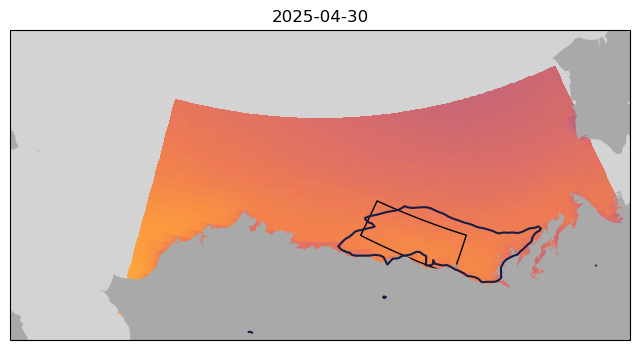

In [1009]:
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-1000000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)
ax.set_title(date.date())

# ax.pcolormesh(dse.longitude, dse.latitude, maps['all']['v10']['mean'] - bg_v, vmin=-10,vmax=10, 
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

# ax.pcolormesh(dse.longitude, dse.latitude, maps['start']['s10']['mean'] - bg_s, vmin=-8,vmax=8, 
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

# ax.pcolormesh(dse.longitude, dse.latitude, total_vec_anom, vmin=5,vmax=10, 
#               cmap=cmocean.cm.haline, transform=ccrs.PlateCarree())



ax.pcolormesh(dse.longitude, dse.latitude, bg_t, vmin=-40,vmax=-10, 
              cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())

# ax.contour(dse.longitude, dse.latitude, maps['all']['dc'], levels=[0.85,0.875,0.9,0.95, 1],
#               cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

ax.contour(dse.longitude, dse.latitude, maps['all']['dc']-bg_dc, levels=[0.8],
              cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None', crs=ccrs.PlateCarree())
# ax.add_geometries([reg_poly2], edgecolor='k', facecolor='None', crs=ccrs.PlateCarree(), zorder=100)


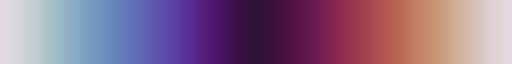

In [541]:
mpl.cm.twilight

In [391]:
def open_daily_winds(year, lat_range, lon_range, time_range = None):
    
    ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
    ds.close()
    if time_range == None:
        ds = ds.sel(latitude = lat_range, longitude = lon_range)
    else:
        ds = ds.sel(time = time_range, latitude = lat_range, longitude = lon_range)
        
    return ds


array([Timestamp('2002-12-01 00:00:00'), Timestamp('2002-12-10 00:00:00'),
       Timestamp('2002-12-23 00:00:00'), Timestamp('2003-01-10 00:00:00'),
       Timestamp('2003-01-19 00:00:00'), Timestamp('2003-01-26 00:00:00'),
       Timestamp('2003-12-11 00:00:00'), Timestamp('2003-12-29 00:00:00'),
       Timestamp('2004-01-11 00:00:00'), Timestamp('2004-12-01 00:00:00'),
       Timestamp('2004-12-17 00:00:00'), Timestamp('2006-03-15 00:00:00'),
       Timestamp('2006-12-16 00:00:00'), Timestamp('2007-02-07 00:00:00'),
       Timestamp('2007-12-03 00:00:00'), Timestamp('2007-12-24 00:00:00'),
       Timestamp('2008-02-12 00:00:00'), Timestamp('2008-12-09 00:00:00'),
       Timestamp('2009-03-10 00:00:00'), Timestamp('2009-12-22 00:00:00'),
       Timestamp('2009-12-28 00:00:00'), Timestamp('2011-01-04 00:00:00'),
       Timestamp('2012-12-23 00:00:00'), Timestamp('2013-01-14 00:00:00'),
       Timestamp('2013-03-06 00:00:00'), Timestamp('2013-03-16 00:00:00'),
       Timestamp('2013-12

In [246]:
lat_range

<xarray.Dataset>
Dimensions:     (valid_time: 194616)
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2003-01-01 ... 2025-03-14T23:00:00
Data variables:
    u10         (valid_time) float32 ...
    v10         (valid_time) float32 ...
    t2m         (valid_time) float32 ...
    sst         (valid_time) float32 ...
    latitude    float64 ...
    longitude   float64 ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            1
    GRIB_subCentre:          0
    history:                 2024-09-02T04:48 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [11]:
GROUPS = {}
GROUPS['era'] = ['u10', 'v10', 'msl', 't2m', 's10']
GROUPS['ppd'] = ['e', 'n','s']
months = [12, 1, 2, 3, 4]

In [12]:

all_vals = {}

for key in ['era', 'ppd']:
    
    filename = f'../data/forcing/regional_{key}_v0.nc'
    ds = xr.open_dataset(filename)
    all_time = pd.to_datetime(ds.date.values.flatten())

    for group in GROUPS[key]:
        all_vals[group] = ds[group].values.flatten()


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [13]:


# start dict to store event times
cats = ['start', 'final', 'all']

seq_times = {}

for cat in cats:
    seq_times[cat] = np.array([])
    
for ss in all_seqs:
    seq_times['all'] = np.append(seq_times['all'], all_seqs[ss])
    seq_times['start'] = np.append(seq_times['start'], all_seqs[ss][0])
    seq_times['final'] = np.append(seq_times['final'], all_seqs[ss][-1])


# start empty arrays to store date
event_vals = {}
non_event_vals = {}

for cat in cats:
    event_vals[cat] = {}
    for key in ['era', 'ppd']:
        for group in GROUPS[key]:
            event_vals[cat][group] = np.array([])
            non_event_vals[group] = np.array([])

            
# grab values at event times           
for tt, time in enumerate(all_time):

    if time not in seq_times['all']:
        for key in ['era', 'ppd']:
            for group in GROUPS[key]:
                non_event_vals[group] = np.append(non_event_vals[group], all_vals[group][tt])
        
    for cat in cats:
        
        # look for date matches
        if time in seq_times[cat]:
#         date_ind = np.where(seq_times[cat] == time)[0]
        
        # if matched, add values
#         if len(date_ind) == 1:
            for key in ['era', 'ppd']:
                for group in GROUPS[key]:
                    event_vals[cat][group] = np.append(event_vals[cat][group], all_vals[group][tt])


/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


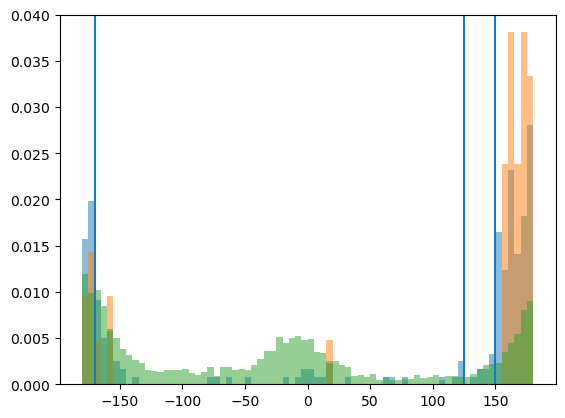

In [84]:

fig, ax = plt.subplots()

# bins = np.arange(-40,40)

# ax.hist(event_vals['all']['e'], bins=bins, alpha=0.5, density=True)
# ax.hist(event_vals['start']['e'], bins=bins, alpha=0.5, density=True)

# ax.hist(event_vals['all']['n'], bins=bins, alpha=0.5, density=True)
# ax.hist(event_vals['all']['e'], bins=bins, alpha=0.5, density=True)

key = 'ppd'
ds = xr.open_dataset(f'../data/forcing/regional_{key}_v0.nc') 
bins = np.arange(-180,181,5)
angles = vectors.vector_angle(event_vals['all']['u10'], event_vals['all']['v10'])
ax.hist(angles, bins=bins, alpha=0.5, density=True);

angles = vectors.vector_angle(event_vals['start']['u10'], event_vals['start']['v10'])
ax.hist(angles, bins=bins, alpha=0.5, density=True);

angles = vectors.vector_angle(non_event_vals['u10'], non_event_vals['v10'])
ax.hist(angles, bins=bins, alpha=0.5, density=True);

ax.axvline(125)
ax.axvline(150)
ax.axvline(-170)

# bins = np.arange(-180,181,5)
# angles = vectors.vector_angle(event_vals['all']['u10'], event_vals['all']['v10'])
# ax.hist(angles, bins=bins, alpha=0.5, density=True);

# angles = vectors.vector_angle(non_event_vals['u10'], non_event_vals['v10'])
# ax.hist(angles, bins=bins, alpha=0.5, density=True);

In [15]:


def grab_regiondata_bytime(dates):
    
    data = {}
    data['time'] = dates
    
    
    key = 'era'
    ds = xr.open_dataset(f'../data/forcing/regional_{key}_v0.nc')  
    cats = ['u10', 'v10', 's10', 'msl', 't2m']
    
    for cat in cats:
        data[cat] = np.array([])
    
    for date in dates:
        month = date.month
        if month == 12:
            YEAR = date.year+1
        else:
            YEAR = date.year
        monthlength = calendar.monthrange(YEAR, month)[-1]
        day = date.day
        for cat in cats:
            data[cat] = np.append(data[cat], ds[cat].sel(year = YEAR, month = date.month, day = day))
        
    key = 'ppd'
    ds = xr.open_dataset(f'../data/forcing/regional_{key}_v0.nc')  
    cats = ['e', 'n', 's']
    
    for cat in cats:
        data[cat] = np.array([])
    
    for date in dates:
        month = date.month
        if month == 12:
            YEAR = date.year+1
        else:
            YEAR = date.year
        monthlength = calendar.monthrange(YEAR, month)[-1]
        day = date.day
        for cat in cats:
            data[cat] = np.append(data[cat], ds[cat].sel(year = YEAR, month = date.month, day = day))
        
    return data

In [584]:
time_range

slice(datetime.datetime(2013, 12, 1, 0, 0), datetime.datetime(2014, 4, 30, 0, 0), None)

In [237]:



year = 2023

DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic15_v5.nc')
time_range = slice(datetime(year-1,12,1), datetime(year,4,30))
DS = DS.sel(time = time_range)
DS['length'] = DS.l_per95 - DS.l_per5
DS['width'] = DS.w_per95 - DS.w_per5

dates = pd.date_range(time_range.start, time_range.stop)
regdata = grab_regiondata_bytime(dates)

/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/opt/anaconda3/envs/SBSpolynya/lib/python3.12/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [238]:
len(regdata['n'])

151

In [239]:


# u = regdata['e']*units('cm/s').to('km/day')
# v = regdata['n']*units('cm/s').to('km/day')
# angles = vectors.vector_angle(u, v)
# along = vectors.comp_along_theta(u, v, (60+90)*units('degree')) 
# open_cond = (angles > 135 * units('degree')) + (angles < -170 * units('degree')) 

u = 0.03*regdata['u10']*units('m/s')
v = 0.03*regdata['v10']*units('m/s')
angles = vectors.vector_angle(u, v)
along = vectors.comp_along_theta(u, v, (25+60+90)*units('degree')) * units('m/s').to('km/day')
wind_speed = np.sqrt((regdata['u10'])**2+(regdata['v10'])**2)
open_angle = (angles > 145 * units('degree')) + (angles < -175 * units('degree')) 
open_cond = open_angle & (wind_speed > 3)


event_times = regdata['time']
consecutive_open = tseries.dates_to_sequences(event_times[open_cond], dt_max = 1 * units('day'))

cum_open = np.zeros(len(along))
for cc in consecutive_open:
    start = np.where(event_times == consecutive_open[cc][0])[0][0]
    final = np.where(event_times == consecutive_open[cc][-1])[0][0]
    cum_open[start:final+1] = np.cumsum(along[start:final+1])


Help on function running_mean in module timeseries.adjust:

running_mean(series, length=3, center=False, address_nans=False)
    Function to calculate running mean of a series (assumes evenly spaced data).

    INPUT:
    - series: (M x 1) array of data to calculate running mean
    - length: length of running mean window
        (either one-sided (window=length+1), or one side of two-sided if center=True (window=2*length + 1))
    - center: if True, calculate two-sided running mean
    - address_nans: if True, address nans in data by taking mean of non-nan values in window
        (else carry any nans to final data)

    OUTPUT:
    - running_mean: (M x 1) array of running mean values

    Latest recorded update:
    01-30-2025



In [240]:


# fig, ax = plt.subplots(figsize=(3,3))

# ax.set_xlim(-1,60)
# ax.set_ylim(-1,60)

# ax.plot(ax.get_xlim(), ax.get_ylim(), lw=0.5, c='k', zorder=-1)

# # ax.bar(years, num_wind_events)
# # ax.scatter(years, num_poly_events, c='k', marker='*')

# ax.scatter(num_wind_events, num_poly_events, c='k', marker='*')

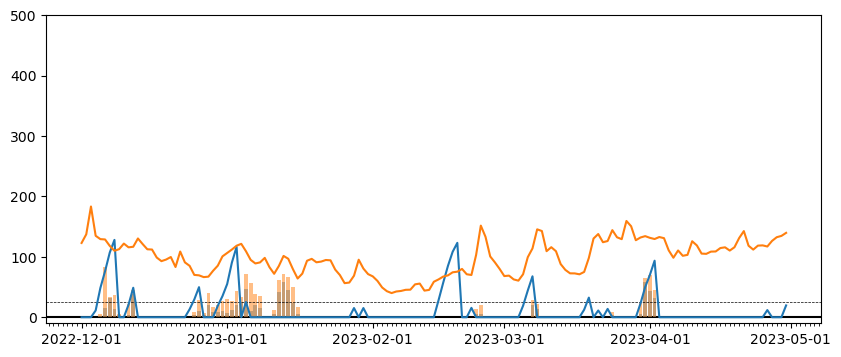

In [241]:


fig, ax = plt.subplots(figsize=(10,4))
ax.set_ylim(-10,500)

plt.axhline(1000/40, c='k', lw=0.5, ls='dashed')

plt.bar(DS.time, DS.extent.values/40, alpha=0.5)
plt.bar(DS.time, DS.length.values, alpha=0.5)
# plt.bar(DS.time, DS.polynya_extent.values / 50)

# plt.plot(event_times, open_along, marker='.')
# plt.plot(event_times, cum_open2, marker='.')
plt.plot(event_times, cum_open)
# plt.plot(event_times, u, marker='.')
# plt.plot(event_times, v, marker='.')


ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.axhline(0, c='k', zorder=-1)


# ax.plot(event_times, -20*regdata['u10'])
# ax.plot(event_times, 20*regdata['v10'])

ax.plot(event_times, 5*(regdata['t2m'] + 40))
# plt.bar(DS.time, DS.extent.values/DS.width.values, alpha=0.5)

In [190]:
cum_open2 = cum_open

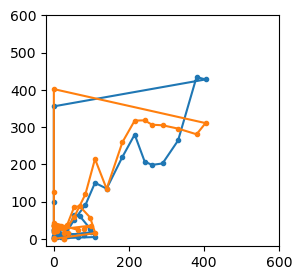

In [236]:
fig, ax = plt.subplots(figsize=(3,3))
ax.set_xlim(-20,600)
ax.set_ylim(-20,600)


ax.plot(cum_open, DS.extent.values/40, marker='.')
ax.plot(cum_open, DS.length.values, marker='.')

In [101]:
np.nanmean(DS['width'])

20.977675430946313

In [ ]:

key = 'era'
mainpath = '../data/forcing/'
filename = f"dailymaps_{key}_v0.nc"
ds = xr.open_dataset(mainpath+filename)

In [61]:
DS.extent > 100

<xarray.DataArray 'extent' (time: 26)>
array([False, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 2023-12-31 2024-01-01 ... 2024-01-25

In [219]:
stats = {}

stats['polynya'] = {}
months = [12,1,2,3,4]

for month in months:
    stats['polynya'][month] = 0

for ss in all_seqs:
    
    for date in all_seqs[ss]:
        
        stats['polynya'][date.month] += 1

In [336]:
all_force = {}


dt_i = timedelta(hours=24)
dt_f = timedelta(hours=24)

for ii in all_seqs.keys():

    # define time range
    ti = all_seqs[ii][0]
    tf = all_seqs[ii][-1] + timedelta(hours=23)
    time_range = slice(ti - dt_i, tf + dt_f)


    # open ERA5 data
    dse = grab_atm(time_range, lat = 70.5 , lon = -140, dt = 'hourly')
    dt = ((pd.to_datetime(dse.time.values) - pd.to_datetime(ti)) / np.timedelta64(1, 's')) * units('s').to('day')
    
    
    all_force[ii] = {}
    all_force[ii]['dt'] = dt
    all_force[ii]['u10'] = dse.u10.values
    all_force[ii]['v10'] = dse.v10.values
    all_force[ii]['msl'] = dse.msl.values / 100
    

In [389]:
stats['ESE_winds'] = {}
stats['strong_winds'] = {}
stats['strong_ESE_winds'] = {}

for month in months:
    stats['ESE_winds'][month] = 0
    stats['strong_winds'][month] = 0
    stats['strong_ESE_winds'][month] = 0

    
for year in years:
    
    print(year)
    
    # open ERA5 data
    time_range = slice(datetime(year,1,1) - timedelta(days=31), datetime(year,1,1) + timedelta(days=120))
    dse = grab_atm(time_range, lat = 70.5 , lon = -140, dt = 'daily')
    year_months = np.array([date.month for date in pd.to_datetime(dse.time.values)])
    
    wind_angles = vectors.vector_angle(dse.u10.values, dse.v10.values)
    wind_speeds = np.sqrt(dse.u10.values**2 + dse.v10.values**2)
    
    for month in months:
        month_angles = wind_angles[year_months == month].magnitude
        month_speeds = wind_speeds[year_months == month]
        
        within_angle_range = (month_angles > 135) & (month_angles < 180)
        within_speed_range = (month_speeds > 7.5)
        
        
        stats['ESE_winds'][month] += np.sum(within_angle_range)
        stats['strong_winds'][month] += np.sum(within_speed_range)
        stats['strong_ESE_winds'][month] += np.sum(within_angle_range&within_speed_range)
        

2018
2019
2020
2021
2022
2023
2024


In [344]:
back_u = np.array([])
back_v = np.array([])
back_m = np.array([])

for year in years:
    
    print(year)
    
    # open ERA5 data
    time_range = slice(datetime(year,1,1) - timedelta(days=31), datetime(year,1,1) + timedelta(days=120))
    dse = grab_atm(time_range, lat = 70.5 , lon = -140, dt = 'daily')
    
    back_u = np.append(back_u, dse.u10.values)
    back_v = np.append(back_v, dse.v10.values)
    back_m = np.append(back_m, dse.msl.values/100)
    
back_u = np.reshape(back_u, (len(years), int(back_u.size/len(years))))
back_v = np.reshape(back_v, (len(years), int(back_v.size/len(years))))
back_m = np.reshape(back_m, (len(years), int(back_m.size/len(years))))

2018
2019
2020
2021
2022
2023
2024


In [ ]:

key = 'era'
mainpath = '../data/forcing/'
filename = f"dailymaps_{key}_v0.nc"
ds = xr.open_dataset(mainpath+filename)

In [309]:
stats

{'polynya': {12: 8, 1: 17, 2: 0, 3: 9, 4: 7}}

In [305]:
stats['polynya']

{12: 8, 1: 17, 2: 0, 3: 9, 4: 7}

[Text(0, 0, '12'),
 Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(3, 0, '3'),
 Text(4, 0, '4')]

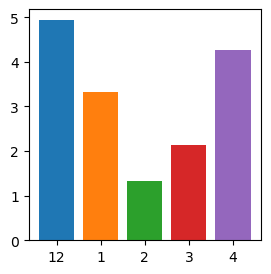

In [220]:
fig, ax = plt.subplots(figsize=(3,3))

for mm, month in enumerate(months):
    
    ax.bar(mm, stats['polynya'][month] / len(years))
#     ax.scatter(mm, stats['ESE_winds'][month] / len(years), c='gray')
#     ax.scatter(mm, stats['strong_ESE_winds'][month] / len(years), c='k')
#     ax.scatter(mm, stats['strong_winds'][month] / len(years), c='lightgray')
    
ax.set_xticks(range(len(months)))
ax.set_xticklabels(months)

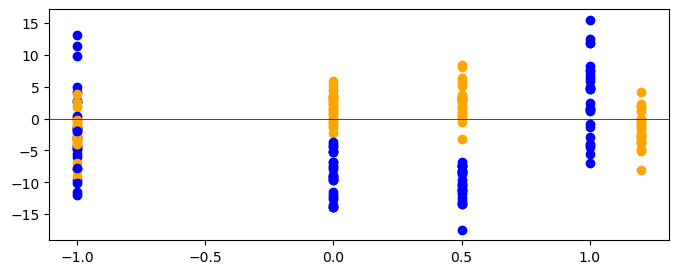

In [237]:
fig, ax = plt.subplots(figsize=(8,3))
ax.axhline(0, c='k', lw=0.5)


u_start = np.array([])
v_start = np.array([])

u_end = np.array([])
v_end = np.array([])

for ii in all_seqs.keys():

    seq = all_force[ii]
    
    
#     event_length = np.max(seq['dt']) - dt_f.days
#     dt_norm = (seq['dt']) / event_length

    dt = seq['dt']
    
    ind_start = np.where(dt == dt[dt_i.days*24])
    ind_end = np.where(dt == dt[-dt_f.days*24])
    
    ind_first = np.where((dt < 1) & (dt > -0.5))
    
    ind_final = np.where((dt > dt.max()-dt_f.days) & (dt < dt.max()))
    
    
    u_start = np.append(u_start, seq['u10'][ind_first])
    v_start = np.append(v_start, seq['v10'][ind_first])
    
    u_end = np.append(u_end, seq['u10'][ind_final])
    v_end = np.append(v_end, seq['v10'][ind_final])
    
    
    ax.scatter([-1], seq['u10'][0], c='b')
    ax.scatter([-1], seq['v10'][0], c='orange')
    
    
    
    ax.scatter([0], seq['u10'][24], c='b')
    ax.scatter([0], seq['v10'][24], c='orange')
    
    ax.scatter([0.5], seq['u10'][24+12], c='b')
    ax.scatter([0.5], seq['v10'][24+12], c='orange')
    
    
    ax.scatter([1], seq['u10'][-1], c='b')
    ax.scatter([1.2], seq['v10'][-1], c='orange')
    
    

In [224]:
dt.max()-dt_f.days

2.9583333333333326

In [340]:
np.nanmean(u_start) + np.nanmean(u_start)

-9.071467411619526

In [382]:
back_u

array([[  3.8389461 ,  -2.82555103,  -9.8918848 , ..., -10.26326752,
        -10.4566555 ,  -2.6198113 ],
       [ -6.86123133,  -3.49951482,  -2.09327817, ...,  -3.21595359,
         -0.82638049,   1.24201941],
       [ -7.43496084,  -9.48820591,  -1.15085363, ...,   4.88615179,
          3.07102418,  -4.65210772],
       ...,
       [ -1.63067245,   5.38300133,   4.05156994, ...,  -7.25163078,
         -2.97059369,  -6.49904585],
       [  1.69804752,   3.3758955 ,  17.41368866, ...,  -3.81374931,
         -6.7414031 ,  -7.88210106],
       [ -9.14648151,  -7.8623395 ,  -4.47210836, ...,  -5.46022844,
         -3.33055878,   1.97247684]])

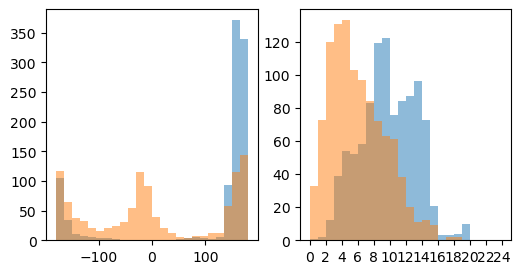

In [385]:
fig, axs = plt.subplots(1,2, figsize=(6,3))

start_angles = vectors.vector_angle(u_start, v_start)
back_angles = vectors.vector_angle(back_u.flatten(), back_v.flatten())

start_speeds = np.sqrt(u_start**2 + v_start**2)
back_speeds = np.sqrt(back_u.flatten()**2 + back_v.flatten()**2)


# bins = np.arange(-25,25,1)
# ax = axs[0]
# ax.hist(u_start, bins=bins, alpha=0.5)
# ax.hist(v_start, bins=bins, alpha=0.5)

# ax = axs[1]
# ax.hist(back_u.flatten(), bins=bins, alpha=0.5)
# ax.hist(back_v.flatten(), bins=bins, alpha=0.5)

bins = np.arange(-180,181,15)
ax = axs[0]
ax.hist(start_angles, bins=bins, alpha=0.5)
ax.hist(back_angles, bins=bins, alpha=0.5)
# ax.set_xticks(bins[::2])


bins = np.arange(0,25,1)
ax = axs[1]
ax.hist(start_speeds, bins=bins, alpha=0.5)
ax.hist(back_speeds, bins=bins, alpha=0.5)
ax.set_xticks(bins[::2])

In [386]:
np.nanpercentile(start_speeds, 25)

7.488388434840175

In [388]:
np.nanpercentile(back_speeds, 75)

8.234381331488112

In [348]:
back_angles

Magnitude,[-47.292895438531524 -136.8563130417885 -179.70275804397193 ... -179.7216754944001 -179.185635744741 -25.922288805872444]
Units,degree


In [316]:
vectors.vector_angle(np.nanmean(u_start), np.nanmean(v_start))

<Quantity(165.294017, 'degree')>

In [315]:
vectors.vector_angle(np.nanmean(back_u.flatten()), np.nanmean(back_v.flatten()))

<Quantity(-170.122596, 'degree')>

In [ ]:

year = 2020

f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc'
# year1
DS1 = xr.open_dataset(file_name(time_range.start.year, dt))
DS1.close()
time_slice = slice(time_range.start, datetime(time_range.start.year, 12, 31, 23))
DS1 = DS1.sel(latitude = lat, longitude = lon, time=time_slice)


In [515]:
all_seqs

{0: [Timestamp('2017-12-03 00:00:00'),
  Timestamp('2017-12-04 00:00:00'),
  Timestamp('2017-12-05 00:00:00'),
  Timestamp('2017-12-06 00:00:00'),
  Timestamp('2017-12-07 00:00:00'),
  Timestamp('2017-12-08 00:00:00'),
  Timestamp('2017-12-09 00:00:00'),
  Timestamp('2017-12-10 00:00:00'),
  Timestamp('2017-12-11 00:00:00'),
  Timestamp('2017-12-12 00:00:00'),
  Timestamp('2017-12-13 00:00:00'),
  Timestamp('2017-12-14 00:00:00'),
  Timestamp('2017-12-15 00:00:00'),
  Timestamp('2017-12-16 00:00:00'),
  Timestamp('2017-12-17 00:00:00'),
  Timestamp('2017-12-18 00:00:00'),
  Timestamp('2017-12-19 00:00:00'),
  Timestamp('2017-12-20 00:00:00'),
  Timestamp('2017-12-21 00:00:00'),
  Timestamp('2017-12-22 00:00:00'),
  Timestamp('2017-12-23 00:00:00'),
  Timestamp('2017-12-24 00:00:00'),
  Timestamp('2017-12-25 00:00:00'),
  Timestamp('2017-12-26 00:00:00'),
  Timestamp('2017-12-27 00:00:00')],
 1: [Timestamp('2018-01-01 00:00:00'),
  Timestamp('2018-01-02 00:00:00'),
  Timestamp('2018-01-

array([2006, 2007, 2008, 2009, 2010, 2011, 2016, 2017, 2018, 2019, 2020,
       2021, 2022, 2023, 2024])

In [114]:

u_bg_sum = np.zeros((29, 161))
v_bg_sum = np.zeros((29, 161))
s_bg_sum = np.zeros((29, 161))
m_bg_sum = np.zeros((29, 161))
t_bg_sum = np.zeros((29, 161))

days_counter = 0

for year in years:
    
    print(year)
    
    # december
    ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year-1}_daily.nc')
    ds.close()
    ds = ds.sel(time = slice(datetime(year-1,12,1), datetime(year-1,12,31)), 
                latitude = lat_range, longitude = lon_range)
    speed = np.sqrt(ds.u10**2+ds.v10**2)
    
    u_bg_sum += ds.u10.sum(dim='time').values
    v_bg_sum += ds.v10.sum(dim='time').values
    s_bg_sum += speed.sum(dim='time').values
    m_bg_sum += ds.msl.sum(dim='time').values/100
    
    days_counter+=len(ds.time.values)
    
    ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_{year-1}.nc')
    ds.close()
    ds = ds.sel(valid_time = slice(datetime(year-1,12,1), datetime(year-1,12,31)), 
                latitude = lat_range, longitude = lon_range)
    t_bg_sum += (ds.t2m - 273.15).sum(dim='valid_time').values

    
    # december
    ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
    ds.close()
    ds = ds.sel(time = slice(datetime(year,1,1), datetime(year,4,30)), 
                latitude = lat_range, longitude = lon_range)
    speed = np.sqrt(ds.u10**2+ds.v10**2)
    
    u_bg_sum += ds.u10.sum(dim='time').values
    v_bg_sum += ds.v10.sum(dim='time').values
    s_bg_sum += speed.sum(dim='time').values
    m_bg_sum += ds.msl.sum(dim='time').values/100
    
    days_counter+=len(ds.time.values)
    
    ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_{year}.nc')
    ds.close()
    ds = ds.sel(valid_time = slice(datetime(year,1,1), datetime(year,4,30)), 
                latitude = lat_range, longitude = lon_range)
    t_bg_sum += (ds.t2m - 273.15).sum(dim='valid_time').values
    
    
    
    
u_bg_mean = u_bg_sum / days_counter
v_bg_mean = v_bg_sum / days_counter
s_bg_mean = s_bg_sum / days_counter
m_bg_mean = m_bg_sum / days_counter
t_bg_mean = t_bg_sum / days_counter
        

2006
2007
2008
2009
2010
2011
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [123]:
u_sum = np.zeros((29, 161))
v_sum = np.zeros((29, 161))
s_sum = np.zeros((29, 161))
m_sum = np.zeros((29, 161))
t_sum = np.zeros((29, 161))

lat_range = slice(75,68)
lon_range = slice(-165,-125)
    
    
counter = 0

for ss in all_seqs:
    
    date = all_seqs[ss][-1]
    
    print(date)
    
    u_event_sum = np.zeros((29, 161))
    v_event_sum = np.zeros((29, 161))
    s_event_sum = np.zeros((29, 161))
    m_event_sum = np.zeros((29, 161))
    t_event_sum = np.zeros((29, 161))
    
    event_counter = 0
    
    for date in all_seqs[ss]:
        year = date.year
        ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
        ds.close()
        ds = ds.sel(time = date, latitude = lat_range, longitude = lon_range)
        speed = np.sqrt(ds.u10**2+ds.v10**2)
        
        u_event_sum += ds.u10.values
        v_event_sum += ds.v10.values
        s_event_sum += speed.values
        m_event_sum += ds.msl.values/100
        
        ds = xr.open_dataset(f'/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_{year}.nc')
        ds.close()
        ds = ds.sel(valid_time = date, latitude = lat_range, longitude = lon_range)
        t_event_sum += (ds.t2m - 273.15).values

        event_counter+=1
        
        
        
    u_event_mean = u_event_sum / event_counter
    v_event_mean = v_event_sum / event_counter
    s_event_mean = s_event_sum / event_counter
    m_event_mean = m_event_sum / event_counter
    t_event_mean = t_event_sum / event_counter
    
    u_sum += u_event_mean
    v_sum += v_event_mean
    s_sum += s_event_mean
    m_sum += m_event_mean
    t_sum += t_event_mean
    
    counter+=1
    
    
u_mean = u_sum / counter
v_mean = v_sum / counter
s_mean = s_sum / counter
m_mean = m_sum / counter
t_mean = t_sum / counter


dc = np.sqrt(u_mean**2+v_mean**2) / s_mean

angles_mean = vectors.vector_angle(u_mean, v_mean).magnitude
angles_mean[angles_mean<0]+=360

2006-03-20 00:00:00
2007-02-10 00:00:00
2007-04-28 00:00:00
2007-12-15 00:00:00
2008-04-26 00:00:00
2008-12-11 00:00:00
2009-03-11 00:00:00
2009-12-30 00:00:00
2011-01-07 00:00:00
2016-02-17 00:00:00
2016-03-07 00:00:00
2016-04-14 00:00:00
2016-04-30 00:00:00
2016-12-08 00:00:00
2017-04-11 00:00:00
2017-04-19 00:00:00
2017-12-26 00:00:00
2018-01-03 00:00:00
2018-01-16 00:00:00
2018-04-12 00:00:00
2018-12-27 00:00:00
2019-01-19 00:00:00
2019-12-19 00:00:00
2020-12-03 00:00:00
2021-01-24 00:00:00
2021-04-30 00:00:00
2022-03-01 00:00:00
2022-03-29 00:00:00
2022-12-09 00:00:00
2022-12-12 00:00:00
2023-01-08 00:00:00
2023-01-15 00:00:00
2023-04-02 00:00:00
2024-01-18 00:00:00
2024-03-24 00:00:00
2024-04-01 00:00:00


In [163]:
dc_bg = np.sqrt(u_bg_mean**2+v_bg_mean**2) / s_bg_mean

In [164]:
total_vec_anom = np.sqrt((u_mean-u_bg_mean)**2 + (v_mean-v_bg_mean)**2)

angles_bg_mean = vectors.vector_angle(u_bg_mean, v_bg_mean).magnitude

angles_bg_mean[angles_bg_mean<0]+=360



In [165]:
total_vec_anom.shape

(29, 161)

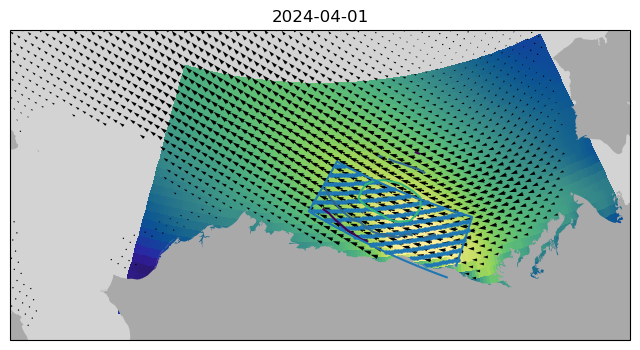

In [249]:
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)

fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))

ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-1000000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)
ax.set_title(date.date())
# geomap.scalebar(ax, loc=(0.55, 0.05), steps= [0,1,2,5,10,20], unit='km', label=None, 
#                 colors=['k', 'w'], edgecolor=None, textsize=9, lw=1, bar_width=0.025,
#                 labelpad=0.015, ticklabelpad=0.01, zorder=100)

# ax.pcolormesh(ds.longitude, ds.latitude, ds.msl/100, vmin=1010, vmax=1030, transform=ccrs.PlateCarree())


# ax.pcolormesh(ds.longitude, ds.latitude, angles_mean-angles_bg_mean, vmin=-60,vmax=60, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


# ax.pcolormesh(ds.longitude, ds.latitude, u_mean-u_bg_mean, vmin=-10,vmax=10, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

# ax.pcolormesh(ds.longitude, ds.latitude, angles_mean, vmin=165-15,vmax=165+15, cmap='RdBu_r', transform=ccrs.PlateCarree())


ax.pcolormesh(ds.longitude, ds.latitude, total_vec_anom, vmin=0,vmax=8, cmap=cmocean.cm.haline, transform=ccrs.PlateCarree())



# ax.pcolormesh(ds.longitude, ds.latitude, t_bg_mean, vmin=-40, vmax=-10, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())
# ax.pcolormesh(ds.longitude, ds.latitude, t_event_mean, vmin=-40, vmax=-10, cmap=cmocean.cm.thermal, transform=ccrs.PlateCarree())


# ax.pcolormesh(ds.longitude, ds.latitude, t_event_mean - t_bg_mean, vmin=-10, vmax=10, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())

# ax.pcolormesh(drift['xx'], drift['yy'], np.nanmean(drift['e'], axis=0), vmin=-10, vmax=10, cmap=cmocean.cm.balance, transform=drift['proj'])


ia=200
ib=300
ja=110
jb=200
# ax.pcolormesh(drift['xx'][ia:ib, ja:jb], drift['yy'][ia:ib, ja:jb], 
#               e_event_mean, vmin=-15, vmax=15, cmap=cmocean.cm.balance, transform=drift['proj'])

# ax.pcolormesh(drift['xx'][ia:ib, ja:jb], drift['yy'][ia:ib, ja:jb], 
#               n_event_mean, vmin=-5, vmax=5, cmap=cmocean.cm.balance, transform=drift['proj'])



# ax.pcolormesh(drift['xx'][ia:ib, ja:jb], drift['yy'][ia:ib, ja:jb], 
#               np.sqrt(e_event_mean**2+n_event_mean**2), vmin=-20, vmax=20, cmap=cmocean.cm.balance, transform=drift['proj'])


dlon_range = (drift['lon'][ia:ib, ja:jb] > 210) & (drift['lon'][ia:ib, ja:jb] < 220)
dlat_range = (drift['lat'][ia:ib, ja:jb] > 70.5) & (drift['lat'][ia:ib, ja:jb] < 73)
mask = (dlon_range & dlat_range)==False
ax.contour(drift['xx'][ia:ib, ja:jb], drift['yy'][ia:ib, ja:jb], 
         ma.masked_where(mask, s_event_mean),  levels=[17,19,21,23], transform=drift['proj'])



# ax.quiver(drift['xx'][ia:ib, ja:jb], drift['yy'][ia:ib, ja:jb],
#          np.mean(drift['u'][:,ia:ib, ja:jb], axis=0), np.mean(drift['v'][:,ia:ib, ja:jb], axis=0), transform=drift['proj'])

E, N = geomap.fix_cartopy_vectors(e_event_mean, n_event_mean, drift['lat'][ia:ib, ja:jb])
ax.quiver(drift['lon'][ia:ib, ja:jb], drift['lat'][ia:ib, ja:jb],
         E, N, transform=ccrs.PlateCarree())

# ax.contour(ds.longitude, ds.latitude, (1013.25 - ds.msl/100), levels=np.arange(-50,50), vmin=-30,vmax=30, cmap=cmocean.cm.balance, transform=ccrs.PlateCarree())


ax.plot(df['lons'], df['lats'], transform=ccrs.PlateCarree())

ax.scatter(longrid[within_region], latgrid[within_region], s=5, transform=ccrs.PlateCarree())


In [212]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

e_sum = np.zeros((100, 90))
n_sum = np.zeros((100, 90))
s_sum = np.zeros((100, 90))
u_sum = np.zeros((100, 90))
v_sum = np.zeros((100, 90))

counter = 0 

for ss in all_seqs:
    
    date = all_seqs[ss][-1]
    
    print(date)

    try:
        drift = icedrift.open_local_file(all_seqs[ss],
                            main_path = '/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/', 
                            filenametype = 'icemotion_daily_nh_25km_{}0101_{}1231_v4.1.nc', 
                            include_units = False)

        e_event_mean = np.nanmean(drift['e'][:, ia:ib, ja:jb], axis=0)
        n_event_mean = np.nanmean(drift['n'][:, ia:ib, ja:jb], axis=0)
        s_event_mean = np.nanmean(np.sqrt(drift['e'][:, ia:ib, ja:jb]**2+drift['n'][:, ia:ib, ja:jb]**2), axis=0)
        u_event_mean = np.nanmean(drift['u'][:, ia:ib, ja:jb], axis=0)
        v_event_mean = np.nanmean(drift['v'][:, ia:ib, ja:jb], axis=0)
        

        e_sum += e_event_mean
        n_sum += n_event_mean
        s_sum += s_event_mean
        u_sum += u_event_mean
        v_sum += v_event_mean

        counter += 1
        
    except:
        print(f'missing {date} seq')
        
e_event_mean = e_sum/counter
n_event_mean = n_sum/counter
s_event_mean = s_sum/counter
u_event_mean = u_sum/counter
v_event_mean = v_sum/counter


warnings.filterwarnings("default", category=RuntimeWarning)

2006-03-20 00:00:00
2007-02-10 00:00:00
2007-04-28 00:00:00
2007-12-15 00:00:00
2008-04-26 00:00:00
2008-12-11 00:00:00
2009-03-11 00:00:00
2009-12-30 00:00:00
2011-01-07 00:00:00
2016-02-17 00:00:00
2016-03-07 00:00:00
2016-04-14 00:00:00
2016-04-30 00:00:00
2016-12-08 00:00:00
2017-04-11 00:00:00
2017-04-19 00:00:00
2017-12-26 00:00:00
2018-01-03 00:00:00
2018-01-16 00:00:00
2018-04-12 00:00:00
2018-12-27 00:00:00
2019-01-19 00:00:00
2019-12-19 00:00:00
2020-12-03 00:00:00
2021-01-24 00:00:00
2021-04-30 00:00:00
2022-03-01 00:00:00
2022-03-29 00:00:00
2022-12-09 00:00:00
2022-12-12 00:00:00
2023-01-08 00:00:00
2023-01-15 00:00:00
2023-04-02 00:00:00
2024-01-18 00:00:00
missing 2024-01-18 00:00:00 seq
2024-03-24 00:00:00
missing 2024-03-24 00:00:00 seq
2024-04-01 00:00:00
missing 2024-04-01 00:00:00 seq


In [ ]:


drift = icedrift.open_local_file(all_seqs[1],
                        main_path = '/Volumes/Jewell_EasyStore/NSIDC-0116_PPdrift/', 
                        filenametype = 'icemotion_daily_nh_25km_{}0101_{}1231_v4.1.nc', 
                        include_units = False)
ia=200
ib=300
ja=110
jb=200

e_event_sum = np.zeros((100, 90))

In [150]:
np.nanmean(drift['e'][:, ia:ib, ja:jb], axis=0)

/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_4034/1880086631.py:1: RuntimeWarning: Mean of empty slice
  np.nanmean(drift['e'][:, ia:ib, ja:jb], axis=0)


array([[       nan,        nan,        nan, ..., -2.8658433, -2.72789  ,
        -2.3834352],
       [       nan,        nan,        nan, ..., -2.8545237, -2.5814705,
        -2.2634492],
       [       nan,        nan,        nan, ..., -3.0014875, -2.6279378,
        -2.2171466],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]], dtype=float32)

In [256]:
grids['pp']['lon'].shape

(100, 90)

In [251]:
drift.keys()

dict_keys(['ds', 'proj', 'u', 'v', 'error', 'xx', 'yy', 'lat', 'lon', 'e', 'n'])

era
pp


In [259]:
grids[key]

{'lat': array([[73.53185 , 73.75072 , 73.96927 , ..., 84.08011 , 83.93147 ,
         83.77819 ],
        [73.467834, 73.68586 , 73.903564, ..., 83.90636 , 83.76184 ,
         83.61262 ],
        [73.40095 , 73.61811 , 73.83492 , ..., 83.72928 , 83.588745,
         83.443436],
        ...,
        [58.883606, 59.003098, 59.121273, ..., 63.101437, 63.067146,
         63.030945],
        [58.682526, 58.801323, 58.918808, ..., 62.871983, 62.837963,
         62.80204 ],
        [58.4809  , 58.59901 , 58.715816, ..., 62.64238 , 62.608624,
         62.57298 ]], dtype=float32),
 'lon': array([[-105.945404, -106.16449 , -106.38954 , ...,  139.63547 ,
          138.01279 ,  136.4688  ],
        [-106.69925 , -106.92752 , -107.16193 , ...,  141.009   ,
          139.39871 ,  137.86241 ],
        [-107.44719 , -107.68439 , -107.92792 , ...,  142.30576 ,
          140.71059 ,  139.18492 ],
        ...,
        [-149.1083  , -149.47029 , -149.83499 , ...,  171.73283 ,
          171.25385 ,  170.7760

## Regional statistics

In [702]:
var_means = {}

groups = ['u10', 'v10', 'msl', 's10']

for group in groups:
    
    var_means[group] = np.array([])


for ss in all_seqs:
    
    date = all_seqs[ss][-1]
    print(date, len(all_seqs[ss]))
    
    for date in all_seqs[ss][:-1]:
        
        year = date.year
        ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
        ds.close()
        ds = ds.sel(time = date, latitude = lat_range, longitude = lon_range)
        speed = np.sqrt(ds.u10**2+ds.v10**2)
        
        curr = {}
        curr['u10'] = geogen.lat_weighted_mean(ds.u10.values[within_region], latgrid[within_region])
        curr['v10'] = geogen.lat_weighted_mean(ds.v10.values[within_region], latgrid[within_region])
        curr['msl'] = geogen.lat_weighted_mean(ds.msl.values[within_region], latgrid[within_region])
        curr['s10'] = geogen.lat_weighted_mean(speed.values[within_region], latgrid[within_region])
        
        for group in groups:
            var_means[group] = np.append(var_means[group], curr[group])
            
            

        

2002-12-02 00:00:00 2
2002-12-11 00:00:00 2
2002-12-24 00:00:00 2
2003-01-12 00:00:00 3
2003-01-21 00:00:00 3
2003-01-28 00:00:00 3
2003-12-22 00:00:00 12
2004-01-01 00:00:00 4
2004-01-13 00:00:00 3
2004-12-05 00:00:00 5
2004-12-21 00:00:00 5
2006-03-20 00:00:00 6
2006-12-18 00:00:00 3
2007-02-10 00:00:00 4
2007-04-28 00:00:00 10
2007-12-15 00:00:00 13
2007-12-25 00:00:00 2
2008-02-14 00:00:00 3
2008-04-26 00:00:00 4
2008-12-11 00:00:00 3
2009-03-11 00:00:00 2
2009-12-23 00:00:00 2
2009-12-30 00:00:00 3
2011-01-07 00:00:00 4
2012-12-25 00:00:00 3
2013-01-16 00:00:00 3
2013-03-11 00:00:00 6
2013-03-17 00:00:00 2
2014-01-08 00:00:00 10
2014-01-29 00:00:00 2
2014-03-02 00:00:00 3
2014-04-26 00:00:00 2
2015-01-02 00:00:00 2
2015-02-25 00:00:00 2
2015-12-17 00:00:00 3
2016-01-30 00:00:00 5
2016-02-17 00:00:00 10
2016-03-07 00:00:00 11
2016-03-10 00:00:00 2
2016-03-23 00:00:00 2
2016-04-14 00:00:00 10
2016-04-30 00:00:00 12
2016-12-08 00:00:00 3
2016-12-19 00:00:00 4
2017-04-11 00:00:00 7
20

In [693]:
e, n = vectors.rotate_vector(var_means['u10'], var_means['v10'], -20*units('degree'))

<IPython.core.display.Javascript object>


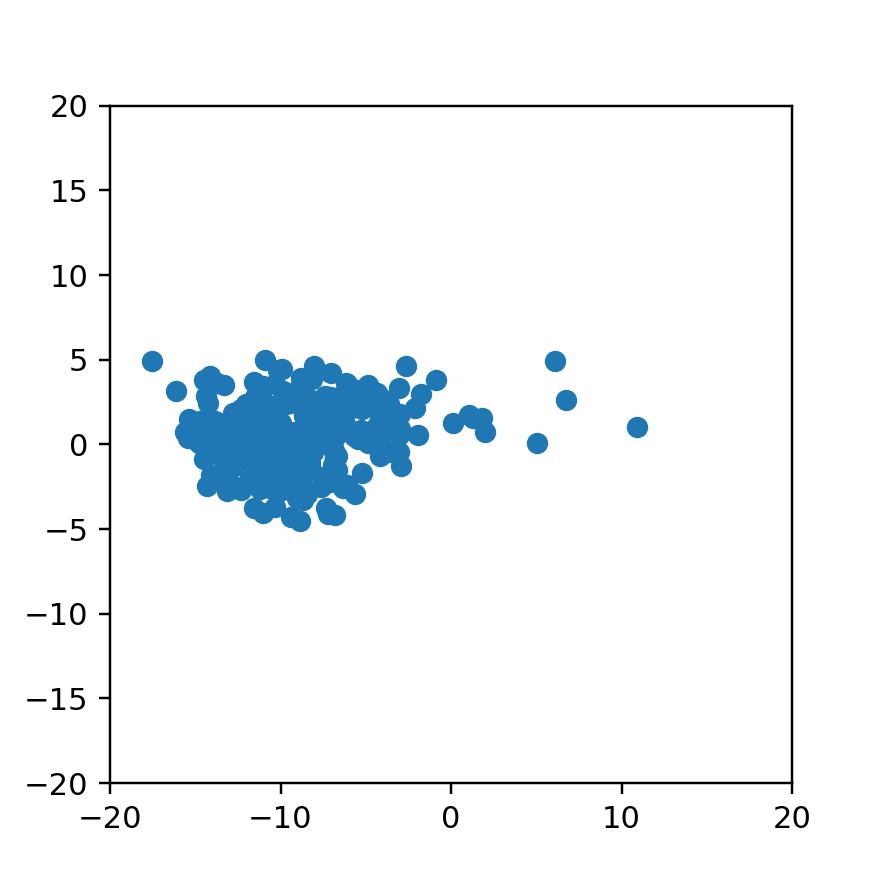

In [703]:

bins = np.arange(-20,20,0.5)

fig, ax = plt.subplots(figsize=(4,4))

size = 20

ax.set_xlim(-size, size)
ax.set_ylim(-size, size)

# plt.hist(var_means['u10'], bins=bins)
# plt.hist(var_means['v10'], bins=bins)


# plt.hist(e, bins=bins, alpha=0.5)
# plt.hist(n, bins=bins, alpha=0.5)

plt.scatter(var_means['u10'], var_means['v10'])


<IPython.core.display.Javascript object>


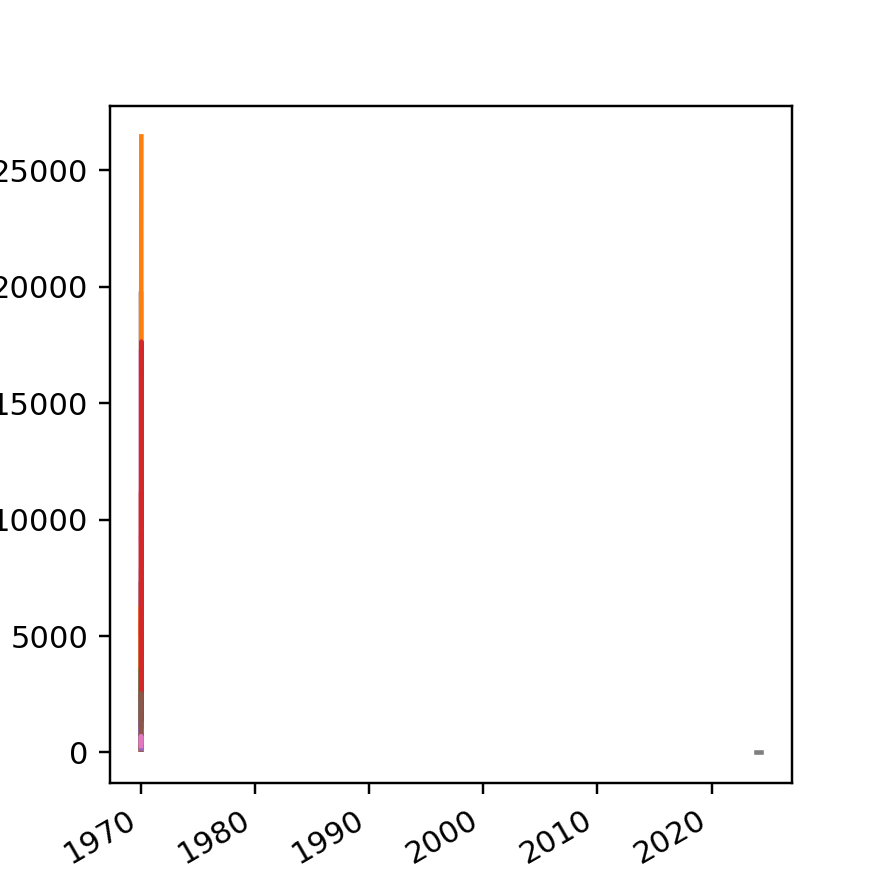

In [710]:
fig, ax = plt.subplots(figsize=(4,4))

for ss in all_sizes:
    
    plt.plot(all_sizes[ss])

In [831]:
all_seqs

{0: [Timestamp('2002-12-01 00:00:00'), Timestamp('2002-12-02 00:00:00')],
 1: [Timestamp('2002-12-10 00:00:00'), Timestamp('2002-12-11 00:00:00')],
 2: [Timestamp('2002-12-23 00:00:00'), Timestamp('2002-12-24 00:00:00')],
 3: [Timestamp('2003-01-10 00:00:00'),
  Timestamp('2003-01-11 00:00:00'),
  Timestamp('2003-01-12 00:00:00')],
 4: [Timestamp('2003-01-19 00:00:00'),
  Timestamp('2003-01-20 00:00:00'),
  Timestamp('2003-01-21 00:00:00')],
 5: [Timestamp('2003-01-26 00:00:00'),
  Timestamp('2003-01-27 00:00:00'),
  Timestamp('2003-01-28 00:00:00')],
 6: [Timestamp('2003-12-11 00:00:00'),
  Timestamp('2003-12-12 00:00:00'),
  Timestamp('2003-12-13 00:00:00'),
  Timestamp('2003-12-14 00:00:00'),
  Timestamp('2003-12-15 00:00:00'),
  Timestamp('2003-12-16 00:00:00'),
  Timestamp('2003-12-17 00:00:00'),
  Timestamp('2003-12-18 00:00:00'),
  Timestamp('2003-12-19 00:00:00'),
  Timestamp('2003-12-20 00:00:00'),
  Timestamp('2003-12-21 00:00:00'),
  Timestamp('2003-12-22 00:00:00')],
 7: [T

In [731]:
all_seqs[5]

[Timestamp('2019-01-15 00:00:00'),
 Timestamp('2019-01-16 00:00:00'),
 Timestamp('2019-01-17 00:00:00'),
 Timestamp('2019-01-18 00:00:00'),
 Timestamp('2019-01-19 00:00:00')]

In [784]:
DS

<xarray.Dataset>
Dimensions:               (time: 16)
Coordinates:
  * time                  (time) datetime64[ns] 2019-12-06 ... 2019-12-21
Data variables: (12/24)
    N                     (time) float64 ...
    extent                (time) float64 nan nan 155.9 975.0 ... 623.8 nan nan
    l_min                 (time) float64 ...
    l_max                 (time) float64 ...
    l_mean                (time) float64 ...
    l_per5                (time) float64 ...
    ...                    ...
    land_extent           (time) float64 ...
    ice_extent            (time) float64 ...
    ocean_extent          (time) float64 ...
    other_polynya_extent  (time) float64 ...
    polynya_extent        (time) float64 ...
    miss_flag             (time) bool ...

In [817]:
all_seqs

{0: [Timestamp('2002-12-01 00:00:00'), Timestamp('2002-12-02 00:00:00')],
 1: [Timestamp('2002-12-10 00:00:00'), Timestamp('2002-12-11 00:00:00')],
 2: [Timestamp('2002-12-23 00:00:00'), Timestamp('2002-12-24 00:00:00')],
 3: [Timestamp('2003-01-10 00:00:00'),
  Timestamp('2003-01-11 00:00:00'),
  Timestamp('2003-01-12 00:00:00')],
 4: [Timestamp('2003-01-19 00:00:00'),
  Timestamp('2003-01-20 00:00:00'),
  Timestamp('2003-01-21 00:00:00')],
 5: [Timestamp('2003-01-26 00:00:00'),
  Timestamp('2003-01-27 00:00:00'),
  Timestamp('2003-01-28 00:00:00')],
 6: [Timestamp('2003-12-11 00:00:00'),
  Timestamp('2003-12-12 00:00:00'),
  Timestamp('2003-12-13 00:00:00'),
  Timestamp('2003-12-14 00:00:00'),
  Timestamp('2003-12-15 00:00:00'),
  Timestamp('2003-12-16 00:00:00'),
  Timestamp('2003-12-17 00:00:00'),
  Timestamp('2003-12-18 00:00:00'),
  Timestamp('2003-12-19 00:00:00'),
  Timestamp('2003-12-20 00:00:00'),
  Timestamp('2003-12-21 00:00:00'),
  Timestamp('2003-12-22 00:00:00')],
 7: [T

In [840]:
ss = 12

event_u = np.array([])
event_v = np.array([])

event_times = pd.date_range(all_seqs[ss][0] - timedelta(days=2), all_seqs[ss][-1] + timedelta(days=2))

print(event_times)

# open data and crop to time range
year = all_seqs[ss][-1].year
if all_seqs[ss][-1].month == 12:
    year+=1
DS = xr.open_dataset(f'./data/polynya_size/daily_polynya_{year}_sic15_v3.nc')
DS = DS.sel(time = event_times)
DS['length'] = DS['l_max'] - DS['l_min']
    
for date in event_times:
    
    year = date.year
    ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_{year}_daily.nc')
    ds.close()
    ds = ds.sel(time = date, latitude = lat_range, longitude = lon_range)
    speed = np.sqrt(ds.u10**2+ds.v10**2)
    
    u = geogen.lat_weighted_mean(ds.u10.values[within_region], latgrid[within_region])
    v = geogen.lat_weighted_mean(ds.v10.values[within_region], latgrid[within_region])
    
    event_u = np.append(event_u, u)
    event_v = np.append(event_v, v)
    
event_ese = vectors.comp_along_theta(event_u, event_v, 165 * units('degree'))

wind_drift = 0.03 * event_ese * units('m/s').to('km/day').magnitude
wind_growth = np.cumsum(wind_drift)

DatetimeIndex(['2006-12-14', '2006-12-15', '2006-12-16', '2006-12-17',
               '2006-12-18', '2006-12-19', '2006-12-20'],
              dtype='datetime64[ns]', freq='D')


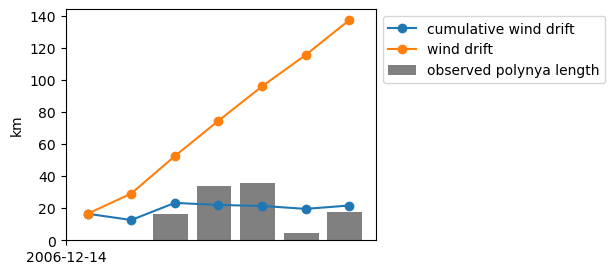

In [841]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(event_times+timedelta(hours=12), wind_drift, marker='o', label='cumulative wind drift')
plt.plot(event_times+timedelta(hours=12), wind_growth, marker='o', label='wind drift')
plt.bar(DS.time, DS.length, color='gray', align='edge', label='observed polynya length')
# plt.bar(DS.time, DS.polynya_extent/50, color='b', align='edge')

ax.set_xticks(event_times[::7])
ax.set_ylabel('km')
plt.legend(bbox_to_anchor=(1,1))

In [804]:

print(DS.time, DS.length)

<xarray.DataArray 'time' (time: 7)>
array(['2022-02-25T00:00:00.000000000', '2022-02-26T00:00:00.000000000',
       '2022-02-27T00:00:00.000000000', '2022-02-28T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000', '2022-03-02T00:00:00.000000000',
       '2022-03-03T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-02-25 2022-02-26 ... 2022-03-03 <xarray.DataArray 'length' (time: 7)>
array([         nan,          nan,  95.06044931, 118.09418008,
       131.63396792,          nan,          nan])
Coordinates:
  * time     (time) datetime64[ns] 2022-02-25 2022-02-26 ... 2022-03-03


In [809]:
DS.polynya_extent

<xarray.DataArray 'polynya_extent' (time: 7)>
array([   0.      ,    0.      , 2106.763029, 3591.492329, 3553.172858,
               nan,    0.      ])
Coordinates:
  * time     (time) datetime64[ns] 2022-02-25 2022-02-26 ... 2022-03-03
Attributes:
    long_name:  extent of polynya forming near HI within region
    units:      km^2

In [34]:
lat_range = slice(76,68)
lon_range = slice(-165,-125)
    
    
ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/ERA5/daily_t2m/ERA5_T2m_daily_2019.nc')
ds.close()

T2M = ds.t2m.sel(latitude=lat_range, longitude=lon_range).sel(valid_time = datetime(2019,1,18))

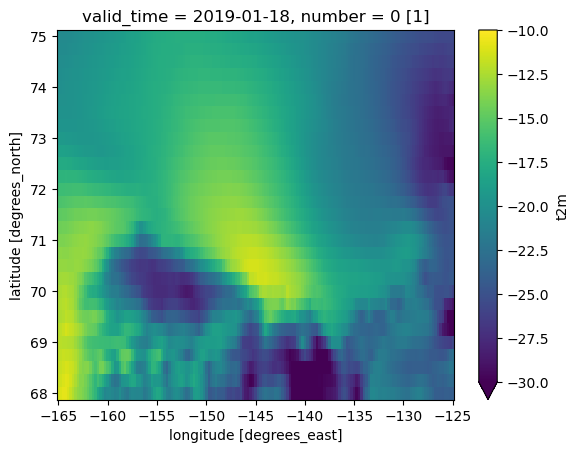

In [35]:
(T2M-273.15).plot(vmin=-30, vmax=-10)